In [7]:
import crowdtruth
import datetime
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import pickle
import random
import seaborn as sns
import warnings

from collections import Counter
from crowdtruth.configuration import DefaultConfig
from dawid_skene import dawid_skene #https://github.com/dallascard/dawid_skene for original
from random import uniform, choice
from sklearn.datasets import fetch_20newsgroups, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=FutureWarning)

### Dawid Skene note

The code used in this library was taken from here: https://github.com/dallascard/dawid_skene. The code has been changed to make it work in Python 3 (original is for Python 2), but **full credit goes to Dallas Card for their original implementation**.

### Parameters

**higher**: Set to true if you want to fix the % of correct answers for each worker to a value between 0.51 and 0.99. At false, the value for each worker will be between a figure determined by the lower expertise model finder and 0.8.

**label_set - (G)**: Can be minimum of 2 and maximum of 20. If you set it to 2, the WBC data set is used, while any other value uses the newsgroups dataset.

**sample_count (S)**: This can be set to any value, but please be aware that this parameter has the highest impact on computational cost (thus more sample = more time). Final sample will be around this figure due to rounding. Recommended to set a maximum of 2000.

**worker_sets (W)**: List of workers you want to generate. For example, at 3 it will generate three different workers with different expertise scores.

**max_iter**: Number of iterations to run each worker set item for. So, if you have a worker_set list of [2,3,5], you will end up with 30 overall iterations (10 for each list item).

**fp_name**: Name of the folder you want to save data to.

In [29]:
higher = False
label_set = 2 #[2,3,5,7,10,15,20]
sample_count = 100 #[50, 100, 250, 500, 1000, 2000]
worker_sets = [3, 5, 8, 10, 13, 15, 18, 20, 30, 40]
max_iter = 10
fp_name = "experiment_{}_{}".format(label_set, "he" if higher else "le")

In [33]:
try:
    os.mkdir(fp_name)
    os.mkdir(fp_name + "/data")
    os.mkdir(fp_name + "/ct_data")
except FileExistsError:
    pass

In [31]:
def worker_mask(skill, data):
    """
    For expertise, determine if answers need to be changed.
    """
    worker_correct = [True for i in range(int(data.shape[0]*skill))] + [False for i in range(data.shape[0] - int(data.shape[0]*skill))]
    random.shuffle(worker_correct) #inplace
    return worker_correct

def change_answers_prob(worker_mask, ground_truth, prob_dict):
    """
    Based on worker mask of expertise, change worker answers to be incorrect so it matches the
    generated expertise score.
    """
    label_possibility = np.unique(ground_truth)
    new_worker_labels = []
    for idx, keep in enumerate(worker_mask):
        if keep:
            new_worker_labels.append(ground_truth[idx])
        else:
            new_choice = np.random.choice(label_possibility, p=prob_dict[ground_truth[idx]])
            new_worker_labels.append(new_choice)
    return new_worker_labels

def maj_vote(answers, worker_count):
    """
    Simple majority vote function. When there is no majority, a random answer is picked from those with
    the highest score.
    """
    label_counts = [Counter(answer) for answer in map(list, zip(*answers))]
    maj_ans = []
    for lab in label_counts:
        top_rated = lab.most_common()
        if top_rated[0][1] >= math.ceil(worker_count/2): #maj winner
            maj_ans.append(top_rated[0][0])
        else:
            maj_ans.append(choice([l[0] for l in top_rated if l[1] == top_rated[0][1]])) # random pick from top
    
    return maj_ans

def label_builder(dist, n=500):
    """
    Get some labels that match the given distribution. This creates your ground truth labels.
    """
    labels = []
    for k, v in label_dist.items():
        label_count = v * n
        labels += [k] * round(label_count)
    return labels

def build_probs(label_count):
    """
    Note: This function determines the probability of a different answer being chosen. It is set to
    give equal probability, provide a custom probability dictionary if you want to experiment with
    label bias.
    """
    prob_dict = {}
    for i in range(label_count):
        temp = np.zeros(label_count)+ 1 / (label_count-1)
        temp[i] = 0
        prob_dict[i] = temp
    return prob_dict

In [32]:
if label_set > 2:
    ### test and train have almost identical distribution
    load_data = fetch_20newsgroups(subset='train', categories=newsgroup_labs[:label_set])
    
    vectorizer = TfidfVectorizer()
    data = vectorizer.fit_transform(load_data.data).todense()
    dataset_name = "Newsgroups"
else:
    load_data = load_breast_cancer()
    data = load_data.data
    dataset_name = "Wisconsin Breast Cancer"
    
labels = load_data.target

label_dist = {k: v / labels.shape[0] for k,v in Counter(labels).items()}

df = pd.DataFrame(data)
df['gt'] = labels

### Lower bound expertise finder model

Below is the model for finding the lowerbound expertise. It randomly assigns labels. This is to give a lower boundary that is more representative of random selection (a 'spammer') given the number of labels rather than selecting 0 (which would result in every single answer from a worker being incorrect). Take a heads or tails situation with a coin, where you are asked to select one in 10 trials - it is highly improbably that you will get no correct answers across the ten trials since the probability of this is 1/2<sup>10</sup> (or 0.09%). Thus, here we run simulations to determine lower-bound weighted f1-score to give a figure more representative of a random selection.

The model is saved as a pickle file.

In [13]:
def lb_finder(data, labels, label_set):
    rand_label_list = []
    lb_f1_scores = []
    for i in range(100):
        random_labels = [random.choice([i for i in range(label_set)]) for i in range (labels.shape[0])]
        rand_label_list.append(random_labels)
        X_train, X_test, y_train, y_test = train_test_split(data, random_labels, test_size=0.3)
        rf = RandomForestClassifier()
        rf.fit(X_train.drop("gt", axis=1), y_train)

        preds = rf.predict(X_test.drop("gt", axis=1))

        lb_f1_scores.append(f1_score(X_test['gt'], preds, average="weighted"))

    lower_bound_data = {
        "f1_scores": lb_f1_scores,
        "rand_labels": rand_label_list,
        "gt": list(labels)
    }

    with open("./{}/lb_model_find_{}.pkl".format(fp_name, label_set), "wb") as f:
        pickle.dump(lower_bound_data, f)
        
    return np.mean(lb_f1_scores)

In [ ]:
## Boundaries each λ for worker expertise will be set at

if higher: #higher expertise experiment
    lb_exp = 0.51
    ub_exp = 0.99
else: #lower expertise experiment
    lb_exp = lb_finder(df, labels, label_set) # Refer to paper to find the lb we got if you prefer to use that
    ub_exp = 0.8

### CrowdTruth config

For the version of CrowdTruth used at the time of the experiments, you need to pass in a config that processes the data.

In [35]:
# Needed for CrowdTruth to work, we've mocked some aspects to fit the functionality
class TestConfig(DefaultConfig):
    inputColumns = ["fake_dat"]
    outputColumns = ["worker_answers"]
    
    #following order - judgment id, unit id, worker id, started time, submitted time
    customPlatformColumns = ["judgement_id", "unit_id", "worker_id", "start_time", "submit_time"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = [str(i) for i in range(label_set)]
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
        return judgments

### Note on label size

Due to the trying to keep a similar distribution to the original data set labels, the number of generated ground truth labels may differ slightly from that selected in the `sample_count` parameter. This should only be by 1 or 2 either side of the parameter selection.

In [36]:
gen_labels = np.array(label_builder(label_dist, n=sample_count))
change_probs = build_probs(label_set)

In [37]:
len(gen_labels) ### label size

100

### Run experiment

Hit play on the cell below to run the experiments with your chosen parameters if you've performed the extra steps. Please note, we've decided to add in a way to save the CrowdTruth data due to how long it can take. This means if you notice something as a mistake or want to change something, you can just load the data in to try save some time.

In [38]:
ws_exp_dict = {}
for ws in worker_sets:
    print("Started WORKER SET " + str(ws) + " at: " + str(datetime.datetime.now()))
    mv_f1_micro = []
    mv_f1_macro = []
    mv_f1_weighted = []
    
    ct_f1_micro = []
    ct_f1_macro = []
    ct_f1_weighted = []
    
    em_f1_micro = []
    em_f1_macro = []
    em_f1_weighted = []
    
    expertise_list = []
    
    work_col = np.ones(gen_labels.shape[0] * ws)
    for it in range(max_iter):
        print("Starting iteration {} for ws {}: {}".format(it, ws, datetime.datetime.now()))
        expertise = [uniform(lb_exp, ub_exp) for worker in range(ws)] #generate a λ for each worker
        masks = [worker_mask(expertise[worker], gen_labels) for worker in range(ws)]
        answers = [change_answers_prob(masks[worker], gen_labels, change_probs) for worker in range(ws)] #T
        
        expertise_list.append(expertise)
        
        print("Completed WORKER GENERATION at: " + str(datetime.datetime.now()))
        
        ### Majority Vote ###
        find_mv = maj_vote(answers, ws) #majority vote
        maj_score_micro = f1_score(gen_labels, find_mv, average="micro")
        mv_f1_micro.append(maj_score_micro)
        maj_score_macro = f1_score(gen_labels, find_mv, average="macro")
        mv_f1_macro.append(maj_score_macro)
        maj_score_weighted = f1_score(gen_labels, find_mv, average="weighted")
        mv_f1_weighted.append(maj_score_weighted)
        
        print("Completed MAJORITY VOTE at: " + str(datetime.datetime.now()))
        
        ### Majority Vote END ###
        
        ### CrowdTruth ###
        psuedo_df = pd.DataFrame(work_col, columns=["fake_dat"])
        psuedo_df['unit_id'] = [i for i in range (gen_labels.shape[0])] * ws
        psuedo_df.reset_index(inplace=True)
        psuedo_df.rename(columns={"index": "judgement_id"}, inplace=True) ### needed 
        psuedo_df["start_time"] = 1 ### required for loading
        psuedo_df["submit_time"] = 1 ### required for loading
        psuedo_df['worker_answers'] = [ans for wrkr in answers for ans in wrkr]
        psuedo_df['worker_id'] = sorted([i+1 for i in range(ws)] * gen_labels.shape[0])
        
        psuedo_df.to_csv("./{}/data/ws{}_iter{}.csv".format(fp_name, ws, it), index=False) ###temp csv file
        
        print("Completed DATA CREATION at: " + str(datetime.datetime.now()))
        
        ct_data, config = crowdtruth.load(
            file = "./{}/data/ws{}_iter{}.csv".format(fp_name, ws, it),
            config = TestConfig()
        )
        
        print("loaded crowd truth at: " + str(datetime.datetime.now()))
        
        results = crowdtruth.run(ct_data, config)
        
        with open("./{}/ct_data/ws{}_iter{}.pkl".format(fp_name, ws, it), "wb") as f:
            pickle.dump(results, f)

        ct = [int(i.most_common()[0][0]) for i in results["units"]["unit_annotation_score"]]
        
        ct_score_micro = f1_score(gen_labels, ct, average="micro")
        ct_f1_micro.append(ct_score_micro)
        ct_score_macro = f1_score(gen_labels, ct, average="macro")
        ct_f1_macro.append(ct_score_macro)
        ct_score_weighted = f1_score(gen_labels, ct, average="weighted")
        ct_f1_weighted.append(ct_score_weighted)
        
        print("Completed CROWDTRUTH at: " + str(datetime.datetime.now()))
        ### CrowdTruth END ###
        
        em_conv = np.array(answers).T
        em_ans = dawid_skene.run({i: {j: [em_conv[i][j]] for j in range(em_conv.shape[1])} for
                                  i in range(em_conv.shape[0])})

        em_score_micro = f1_score(gen_labels, em_ans.argmax(axis=1), average="micro")
        em_f1_micro.append(em_score_micro)
        em_score_macro = f1_score(gen_labels, em_ans.argmax(axis=1), average="macro")
        em_f1_macro.append(em_score_macro)
        em_score_weighted = f1_score(gen_labels, em_ans.argmax(axis=1), average="weighted")
        em_f1_weighted.append(em_score_weighted)
        print("Completed EXPECTATION MAXIMISATION at: " + str(datetime.datetime.now()))
        
    ws_exp_dict["ws_" + str(ws)] = {
        "worker_count": ws,
        "expertise_scores": expertise_list,
        "mv_f1_micro": mv_f1_micro,
        "mv_f1_macro": mv_f1_macro,
        "mv_f1_weighted": mv_f1_weighted,
        "ct_f1_micro": ct_f1_micro,
        "ct_f1_macro": ct_f1_macro,
        "ct_f1_weighted": ct_f1_weighted,
        "em_f1_micro": em_f1_micro,
        "em_f1_macro": em_f1_macro,
        "em_f1_weighted": em_f1_weighted,
    }
    
    with open("./{}/ws_exp_".format(fp_name) + str(ws) + ".json", "w") as f:
        json.dump(ws_exp_dict["ws_" + str(ws)], f, indent=3)
        
    print("Completed worker set: " + str(ws))

print("Completed at: " + str(datetime.datetime.now()))

Started WORKER SET 3 at: 2021-02-11 12:22:14.390914
Starting iteration 0 for ws 3: 2021-02-11 12:22:14.390914
Completed WORKER GENERATION at: 2021-02-11 12:22:14.394915
Completed MAJORITY VOTE at: 2021-02-11 12:22:14.398900
Completed DATA CREATION at: 2021-02-11 12:22:14.408916
loaded crowd truth at: 2021-02-11 12:22:15.552900
Completed CROWDTRUTH at: 2021-02-11 12:22:15.728260
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -206.0958888381824
2 	 -205.5035653779874 	0.008428	0.246241
3 	 -205.2597980910942 	0.006598	0.139623
4 	 -205.13385369822564 	0.005472	0.093709
5 	 -205.05942895186638 	0.004692	0.072555
6 	 -205.01195236791935 	0.004107	0.057458
7 	 -204.98043554334708 	0.003650	0.047703
8 	 -204.9591182193521 	0.003283	0.040114
9 	 -204.94456882239544 	0.002987	0.033595
10 	 -204.93456193706413 	0.002749	0.028052
11 	 -204.92759223253285 	0.002560	0.023400
12 	 -204.9226299088334 	0.002411	0.019548
13 	 -204.91897489030418 	0.002296	0.016398
14 	 -20

37 	 -205.67715008108726 	0.000917	0.011349
38 	 -205.67576297986673 	0.000919	0.010880
39 	 -205.67448224916492 	0.000921	0.010420
40 	 -205.67329963486674 	0.000921	0.009968
41 	 -205.6722076415767 	0.000921	0.009525
42 	 -205.67119938907345 	0.000921	0.009091
43 	 -205.67026850585856 	0.000920	0.008668
44 	 -205.66940905212417 	0.000918	0.008255
45 	 -205.66861546538607 	0.000917	0.007853
46 	 -205.66788252304084 	0.000915	0.007463
47 	 -205.66720531709285 	0.000912	0.007084
48 	 -205.66657923723116 	0.000910	0.006719
49 	 -205.66599995926768 	0.000907	0.006366
50 	 -205.6654634366828 	0.000904	0.006053
51 	 -205.66496589363138 	0.000902	0.005803
52 	 -205.66450381826718 	0.000899	0.005563
53 	 -205.66407395565227 	0.000896	0.005333
54 	 -205.66367329982782 	0.000893	0.005112
55 	 -205.66329908485318 	0.000890	0.004901
56 	 -205.66294877479777 	0.000887	0.004699
57 	 -205.66262005277596 	0.000885	0.004507
58 	 -205.66231080919465 	0.000882	0.004324
59 	 -205.66201912941426 	0.000879

89 	 -203.77449295242567 	0.002586	0.003758
90 	 -203.77366824449922 	0.002589	0.003770
91 	 -203.77284104201502 	0.002592	0.003781
92 	 -203.77201129147127 	0.002595	0.003793
93 	 -203.77117894134608 	0.002598	0.003804
94 	 -203.7703439419432 	0.002601	0.003816
95 	 -203.7695062452452 	0.002604	0.003828
96 	 -203.7686658047834 	0.002607	0.003840
97 	 -203.76782257551815 	0.002610	0.003852
98 	 -203.766976513725 	0.002613	0.003865
99 	 -203.76612757689588 	0.002616	0.003877
100 	 -203.76527572364162 	0.002619	0.003890
101 	 -203.76442091360568 	0.002622	0.003902
Class marginals
[0.55 0.45]
Error rates
[[[0.54 0.46]
  [0.34 0.66]]

 [[0.48 0.52]
  [0.25 0.75]]

 [[0.41 0.59]
  [0.7  0.3 ]]]
Incidence-of-error rates
[[0.3  0.21]
 [0.19 0.29]]
[[0.27 0.23]
 [0.14 0.33]]
[[0.23 0.26]
 [0.39 0.13]]
Patient classes
0 [0.8799 0.1201]
1 [0.6835 0.3165]
2 [0.4906 0.5094]
3 [0.4906 0.5094]
4 [0.4906 0.5094]
5 [0.5439 0.4561]
6 [0.4406 0.5594]
7 [0.7657 0.2343]
8 [0.6835 0.3165]
9 [0.26 0.74]
10 

loaded crowd truth at: 2021-02-11 12:22:23.370802
Completed CROWDTRUTH at: 2021-02-11 12:22:23.556810
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -207.64033048768366
2 	 -206.18790587972106 	0.005917	0.353785
3 	 -205.43244927554983 	0.002609	0.244145
4 	 -204.93338070164776 	0.000451	0.225452
5 	 -204.60437028788755 	0.001074	0.187292
6 	 -204.3883878095447 	0.002209	0.142866
7 	 -204.22631668779056 	0.003124	0.115387
8 	 -204.07337805924828 	0.003943	0.117462
9 	 -203.9037643402285 	0.004726	0.124087
10 	 -203.70619809517862 	0.005469	0.133143
11 	 -203.4804199602869 	0.006123	0.141935
12 	 -203.2361884238565 	0.006612	0.147517
13 	 -202.99156221842827 	0.006862	0.147170
14 	 -202.76739011523924 	0.006842	0.139272
15 	 -202.57910618459096 	0.006585	0.124182
16 	 -202.431297109301 	0.006179	0.104357
17 	 -202.3189492606849 	0.005715	0.083322
18 	 -202.23301463982114 	0.005255	0.064173
19 	 -202.16520182301377 	0.004823	0.048635
20 	 -202.10975536794072 

37 	 -204.19388348438926 	0.001832	0.008075
38 	 -204.19264680118664 	0.001829	0.007844
39 	 -204.19145450619496 	0.001825	0.007622
40 	 -204.19030421165434 	0.001822	0.007405
41 	 -204.18919361951706 	0.001818	0.007193
42 	 -204.18812052763016 	0.001814	0.006987
43 	 -204.18708283369472 	0.001811	0.006787
44 	 -204.1860785372978 	0.001807	0.006593
45 	 -204.1851057403189 	0.001803	0.006404
46 	 -204.1841626460066 	0.001799	0.006222
47 	 -204.18324755698993 	0.001795	0.006046
48 	 -204.18235887247073 	0.001792	0.005875
49 	 -204.18149508480647 	0.001788	0.005710
50 	 -204.18065477566262 	0.001784	0.005551
51 	 -204.17983661188413 	0.001780	0.005397
52 	 -204.1790393412146 	0.001777	0.005249
53 	 -204.1782617879535 	0.001773	0.005105
54 	 -204.17750284863476 	0.001769	0.004967
55 	 -204.17676148778466 	0.001766	0.004834
56 	 -204.1760367338017 	0.001762	0.004705
57 	 -204.17532767499034 	0.001759	0.004581
58 	 -204.17463345576851 	0.001756	0.004462
59 	 -204.17395327306582 	0.001752	0.0

94 	 -196.47058938150755 	0.000075	0.000249
95 	 -196.47058702181292 	0.000071	0.000233
96 	 -196.47058495836814 	0.000066	0.000219
97 	 -196.47058315376853 	0.000062	0.000206
98 	 -196.47058157535585 	0.000058	0.000193
99 	 -196.47058019461397 	0.000055	0.000181
100 	 -196.47057898664113 	0.000051	0.000170
101 	 -196.47057792969096 	0.000048	0.000159
Class marginals
[0.65 0.35]
Error rates
[[[0.67 0.33]
  [0.26 0.74]]

 [[0.66 0.34]
  [0.   1.  ]]

 [[0.6  0.4 ]
  [0.1  0.9 ]]]
Incidence-of-error rates
[[0.44 0.11]
 [0.17 0.26]]
[[0.43 0.12]
 [0.   0.35]]
[[0.39 0.14]
 [0.07 0.31]]
Patient classes
0 [1. 0.]
1 [0.9084 0.0916]
2 [1. 0.]
3 [0.9084 0.0916]
4 [1. 0.]
5 [0.9084 0.0916]
6 [1. 0.]
7 [0.6253 0.3747]
8 [1. 0.]
9 [1. 0.]
10 [1. 0.]
11 [0.9084 0.0916]
12 [0.9084 0.0916]
13 [1. 0.]
14 [1. 0.]
15 [1. 0.]
16 [1. 0.]
17 [1. 0.]
18 [1. 0.]
19 [1. 0.]
20 [1. 0.]
21 [1. 0.]
22 [1. 0.]
23 [1. 0.]
24 [0.9084 0.0916]
25 [1. 0.]
26 [1. 0.]
27 [1. 0.]
28 [0.9084 0.0916]
29 [0.4238 0.5762]
30

loaded crowd truth at: 2021-02-11 12:22:31.206042
Completed CROWDTRUTH at: 2021-02-11 12:22:31.386034
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -209.20518225752957
2 	 -207.84078423376948 	0.002913	0.340102
3 	 -207.11227429805112 	0.001455	0.189673
4 	 -206.60938944013765 	0.000506	0.177316
5 	 -206.24030254993357 	0.000259	0.170925
6 	 -205.98073185271187 	0.000934	0.151728
7 	 -205.81249589166552 	0.001531	0.124939
8 	 -205.7119193645311 	0.002034	0.096391
9 	 -205.65511213618555 	0.002435	0.070572
10 	 -205.62366654352212 	0.002738	0.049697
11 	 -205.6058778748492 	0.002956	0.036069
12 	 -205.59518852239646 	0.003107	0.027352
13 	 -205.5881919411373 	0.003208	0.022082
14 	 -205.5831790070594 	0.003272	0.018317
15 	 -205.57929281580596 	0.003311	0.015409
16 	 -205.57609137504016 	0.003331	0.013161
17 	 -205.57333472133755 	0.003339	0.011632
18 	 -205.57088387785902 	0.003339	0.010342
19 	 -205.56865282338785 	0.003333	0.009249
20 	 -205.566585098640

57 	 -202.30303951601712 	0.000293	0.000870
58 	 -202.3030169607372 	0.000292	0.000844
59 	 -202.30299506205918 	0.000291	0.000819
60 	 -202.30297378206748 	0.000290	0.000795
61 	 -202.30295308538567 	0.000290	0.000771
62 	 -202.3029329389989 	0.000289	0.000749
63 	 -202.3029133120907 	0.000288	0.000727
64 	 -202.3028941758913 	0.000287	0.000706
65 	 -202.30287550353654 	0.000286	0.000685
66 	 -202.30285726993623 	0.000285	0.000666
67 	 -202.30283945165226 	0.000284	0.000647
68 	 -202.3028220267859 	0.000283	0.000634
69 	 -202.30280497487297 	0.000282	0.000627
70 	 -202.30278827678325 	0.000282	0.000625
71 	 -202.3027719146325 	0.000281	0.000623
72 	 -202.30275587169558 	0.000280	0.000621
73 	 -202.3027401323292 	0.000279	0.000619
74 	 -202.3027246818973 	0.000278	0.000617
75 	 -202.30270950670396 	0.000277	0.000615
76 	 -202.30269459392926 	0.000276	0.000613
77 	 -202.30267993157014 	0.000275	0.000611
78 	 -202.3026655083854 	0.000274	0.000609
79 	 -202.30265131384445 	0.000273	0.0006

loaded crowd truth at: 2021-02-11 12:22:38.299980
Completed CROWDTRUTH at: 2021-02-11 12:22:38.564192
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -342.77096734092834
2 	 -342.02855530122923 	0.002155	0.357645
3 	 -341.4720067983445 	0.002115	0.310072
4 	 -341.03031128716736 	0.002259	0.270847
5 	 -340.7006380324567 	0.002420	0.228878
6 	 -340.47779981400134 	0.002475	0.184162
7 	 -340.3396174428809 	0.002369	0.139684
8 	 -340.2570865184431 	0.002126	0.100320
9 	 -340.20595497180193 	0.001804	0.069198
10 	 -340.1705647035133 	0.001460	0.050921
11 	 -340.1423692207481 	0.001128	0.046319
12 	 -340.1172353753841 	0.000826	0.047728
13 	 -340.09337942337476 	0.000555	0.048503
14 	 -340.07015787919926 	0.000315	0.048655
15 	 -340.04744146546415 	0.000101	0.048209
16 	 -340.02530841175627 	0.000089	0.047208
17 	 -340.0038975890896 	0.000257	0.045726
18 	 -339.98334041509855 	0.000404	0.043856
19 	 -339.963732850594 	0.000533	0.041703
20 	 -339.94512851726705 	0.

33 	 -335.2106307026706 	0.005246	0.023832
34 	 -335.19849491520756 	0.005035	0.022879
35 	 -335.18701451858465 	0.004830	0.021944
36 	 -335.1761586923338 	0.004632	0.021028
37 	 -335.16589659673207 	0.004442	0.020136
38 	 -335.1561977245711 	0.004259	0.019270
39 	 -335.14703218372074 	0.004082	0.018431
40 	 -335.13837091671127 	0.003913	0.017620
41 	 -335.1301858647778 	0.003751	0.016839
42 	 -335.1224500841805 	0.003595	0.016088
43 	 -335.1151378224596 	0.003445	0.015367
44 	 -335.10822456176027 	0.003302	0.014675
45 	 -335.1016870356428 	0.003165	0.014013
46 	 -335.09550322499575 	0.003034	0.013395
47 	 -335.08965233785193 	0.002908	0.012820
48 	 -335.08411477714196 	0.002788	0.012271
49 	 -335.07887209970784 	0.002673	0.011745
50 	 -335.0739069692837 	0.002563	0.011241
51 	 -335.0692031056149 	0.002457	0.010760
52 	 -335.0647452314188 	0.002357	0.010300
53 	 -335.0605190185249 	0.002260	0.009860
54 	 -335.0565110342018 	0.002168	0.009439
55 	 -335.0527086884444 	0.002079	0.009037
5

75 	 -339.4396660506675 	0.005287	0.028309
76 	 -339.42640664322806 	0.005085	0.027454
77 	 -339.4138887822025 	0.004882	0.026562
78 	 -339.4021118236377 	0.004678	0.025642
79 	 -339.39106837952045 	0.004474	0.024698
80 	 -339.3807448807155 	0.004272	0.023740
81 	 -339.3711222756014 	0.004073	0.022772
82 	 -339.3621768237781 	0.003877	0.021802
83 	 -339.3538809430636 	0.003685	0.020837
84 	 -339.34620406992246 	0.003498	0.019884
85 	 -339.33911349788616 	0.003317	0.018960
86 	 -339.332575164683 	0.003141	0.018052
87 	 -339.3265543659282 	0.002971	0.017163
88 	 -339.3210163805543 	0.002808	0.016298
89 	 -339.31592700008355 	0.002651	0.015458
90 	 -339.31125295991137 	0.002501	0.014645
91 	 -339.30696227570326 	0.002358	0.013862
92 	 -339.3030244916928 	0.002221	0.013108
93 	 -339.2994108501496 	0.002091	0.012386
94 	 -339.2960943926705 	0.001968	0.011694
95 	 -339.2930500044135 	0.001851	0.011034
96 	 -339.29025441216965 	0.001740	0.010405
97 	 -339.2876861464207 	0.001636	0.009806
98 	

loaded crowd truth at: 2021-02-11 12:22:49.001179
Completed CROWDTRUTH at: 2021-02-11 12:22:49.265814
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -334.7888733332602
2 	 -333.7802520532872 	0.002828	0.460377
3 	 -333.3110831718994 	0.000340	0.307017
4 	 -333.13078360487475 	0.001857	0.183635
5 	 -333.0683581922772 	0.003235	0.101910
6 	 -333.0455219467373 	0.003955	0.054803
7 	 -333.0349282299452 	0.004278	0.033204
8 	 -333.0282846057941 	0.004387	0.022460
9 	 -333.0231688365874 	0.004389	0.017305
10 	 -333.01882357440326 	0.004337	0.014482
11 	 -333.0149638286968 	0.004263	0.013822
12 	 -333.01145143859964 	0.004179	0.013310
13 	 -333.00820363190314 	0.004095	0.012827
14 	 -333.0051642392044 	0.004012	0.012370
15 	 -333.00229251005567 	0.003934	0.012074
16 	 -332.9995575726213 	0.003861	0.011862
17 	 -332.99693515698874 	0.003793	0.011668
18 	 -332.99440547421347 	0.003730	0.011677
19 	 -332.9919517905293 	0.003672	0.011702
20 	 -332.9895594531621 	0.003

31 	 -340.12042835548937 	0.002454	0.032952
32 	 -340.1110334214065 	0.002434	0.031189
33 	 -340.1021850638772 	0.002410	0.029650
34 	 -340.09380420956177 	0.002382	0.028288
35 	 -340.0858391663352 	0.002352	0.027067
36 	 -340.0782537727415 	0.002320	0.025954
37 	 -340.07102058718334 	0.002286	0.024928
38 	 -340.0641171313681 	0.002252	0.023970
39 	 -340.05752389000384 	0.002217	0.023067
40 	 -340.05122327393644 	0.002182	0.022211
41 	 -340.04519908905104 	0.002147	0.021394
42 	 -340.0394362597111 	0.002112	0.020612
43 	 -340.03392067539323 	0.002077	0.019862
44 	 -340.0286390950788 	0.002043	0.019143
45 	 -340.0235790784073 	0.002009	0.018452
46 	 -340.0187289296585 	0.001975	0.017788
47 	 -340.0140776486261 	0.001942	0.017150
48 	 -340.00961488595624 	0.001909	0.016538
49 	 -340.005330901943 	0.001877	0.015951
50 	 -340.00121652830796 	0.001846	0.015388
51 	 -339.9972631326603 	0.001814	0.014847
52 	 -339.9934625853951 	0.001784	0.014329
53 	 -339.98980722881134 	0.001754	0.013833
54

82 	 -332.8475561217677 	0.000618	0.002880
83 	 -332.8473370553885 	0.000600	0.002796
84 	 -332.8471295661007 	0.000582	0.002716
85 	 -332.8469329603378 	0.000565	0.002639
86 	 -332.84674659234366 	0.000549	0.002564
87 	 -332.84656986033485 	0.000533	0.002492
88 	 -332.8464022030245 	0.000518	0.002422
89 	 -332.84624309646955 	0.000504	0.002355
90 	 -332.8460920512007 	0.000489	0.002290
91 	 -332.8459486096138 	0.000476	0.002228
92 	 -332.84581234358495 	0.000463	0.002167
93 	 -332.84568285229807 	0.000450	0.002109
94 	 -332.84555976025285 	0.000438	0.002053
95 	 -332.84544271544013 	0.000426	0.001998
96 	 -332.84533138767233 	0.000415	0.001945
97 	 -332.8452254670467 	0.000404	0.001894
98 	 -332.84512466253125 	0.000393	0.001845
99 	 -332.8450287006654 	0.000382	0.001797
100 	 -332.84493732436334 	0.000372	0.001750
101 	 -332.8448502918052 	0.000363	0.001705
Class marginals
[0.68 0.32]
Error rates
[[[0.54 0.46]
  [0.24 0.76]]

 [[0.37 0.63]
  [0.5  0.5 ]]

 [[0.63 0.37]
  [0.07 0.93]]

loaded crowd truth at: 2021-02-11 12:22:59.839458
Completed CROWDTRUTH at: 2021-02-11 12:23:00.098451
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -343.55853662330713
2 	 -343.1901096529581 	0.001192	0.274223
3 	 -343.0027367933118 	0.000663	0.187522
4 	 -342.89237871793654 	0.000319	0.137276
5 	 -342.8203347271574 	0.000078	0.104968
6 	 -342.7694373227929 	0.000100	0.082663
7 	 -342.7310717708404 	0.000239	0.066536
8 	 -342.7004943420377 	0.000352	0.061439
9 	 -342.67489140805657 	0.000448	0.059927
10 	 -342.6524863209653 	0.000529	0.059056
11 	 -342.632093891377 	0.000599	0.058652
12 	 -342.6128837030274 	0.000659	0.058579
13 	 -342.5942482231533 	0.000710	0.058728
14 	 -342.5757268987099 	0.000750	0.059003
15 	 -342.55696191160575 	0.000779	0.059316
16 	 -342.53767286075805 	0.000797	0.059588
17 	 -342.51764343877926 	0.000804	0.059745
18 	 -342.49671616623795 	0.000798	0.059718
19 	 -342.47479273780976 	0.000781	0.059447
20 	 -342.4518380995809 	0.000

35 	 -543.8476369051306 	0.015634	0.106134
36 	 -543.7462574799783 	0.015411	0.107667
37 	 -543.6437381484238 	0.015125	0.108802
38 	 -543.5406046679894 	0.014784	0.109522
39 	 -543.4373018577453 	0.014398	0.109823
40 	 -543.334162294479 	0.013975	0.110040
41 	 -543.2313845812753 	0.013527	0.112352
42 	 -543.1290261507281 	0.013061	0.115283
43 	 -543.0270144724866 	0.012587	0.118609
44 	 -542.9251786757674 	0.012107	0.121895
45 	 -542.8233018296794 	0.011622	0.125496
46 	 -542.7211935420377 	0.011130	0.128805
47 	 -542.6187833504869 	0.010624	0.131623
48 	 -542.5162351978965 	0.010095	0.133718
49 	 -542.414076239323 	0.009533	0.134819
50 	 -542.3133129553561 	0.008931	0.134628
51 	 -542.2154764639831 	0.008286	0.132879
52 	 -542.122519242774 	0.007604	0.129420
53 	 -542.0365148980197 	0.006900	0.124307
54 	 -541.9592084651855 	0.006203	0.117859
55 	 -541.891579063179 	0.005544	0.110694
56 	 -541.8336108525172 	0.004952	0.103479
57 	 -541.7843697272374 	0.004448	0.096639
58 	 -541.74232

loaded crowd truth at: 2021-02-11 12:23:10.853263
Completed CROWDTRUTH at: 2021-02-11 12:23:11.220201
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -545.5152876752487
2 	 -544.3208379867575 	0.000905	0.540599
3 	 -543.4423037808733 	0.002939	0.466053
4 	 -542.9314930161561 	0.004884	0.342398
5 	 -542.6785237598057 	0.005993	0.219603
6 	 -542.5574341486641 	0.006291	0.131983
7 	 -542.4940458913347 	0.006105	0.079400
8 	 -542.45529676249 	0.005706	0.059178
9 	 -542.427947516337 	0.005240	0.051863
10 	 -542.4067002360124 	0.004776	0.047357
11 	 -542.3892729071559 	0.004341	0.043376
12 	 -542.3745538021228 	0.003944	0.040104
13 	 -542.3619183404167 	0.003585	0.038567
14 	 -542.3509665625293 	0.003262	0.036966
15 	 -542.3414151050943 	0.002973	0.035122
16 	 -542.3330486933738 	0.002713	0.033173
17 	 -542.3256961463362 	0.002480	0.031206
18 	 -542.3192172882209 	0.002270	0.029276
19 	 -542.3134951217827 	0.002080	0.027417
20 	 -542.3084307513026 	0.001909	0.0257

28 	 -540.7420803226671 	0.004322	0.018445
29 	 -540.7386349323451 	0.004239	0.018292
30 	 -540.7353005537295 	0.004163	0.018152
31 	 -540.73206617207 	0.004091	0.018027
32 	 -540.7289216809984 	0.004024	0.017915
33 	 -540.7258577904064 	0.003962	0.017817
34 	 -540.7228659450981 	0.003904	0.017732
35 	 -540.7199382523129 	0.003850	0.017660
36 	 -540.7170674167044 	0.003800	0.017599
37 	 -540.7142466816965 	0.003754	0.017551
38 	 -540.7114697763474 	0.003712	0.017515
39 	 -540.7087308670135 	0.003673	0.017489
40 	 -540.7060245132062 	0.003637	0.017475
41 	 -540.7033456271225 	0.003604	0.017471
42 	 -540.7006894364004 	0.003574	0.017478
43 	 -540.6980514496908 	0.003548	0.017523
44 	 -540.6954274246882 	0.003524	0.017577
45 	 -540.6928133383144 	0.003503	0.017640
46 	 -540.6902053587407 	0.003484	0.017710
47 	 -540.6875998190145 	0.003468	0.017789
48 	 -540.6849931920323 	0.003455	0.017876
49 	 -540.682382066653 	0.003444	0.017971
50 	 -540.6797631247418 	0.003435	0.018074
51 	 -540.6771

81 	 -531.13579949471 	0.000002	0.000011
82 	 -531.1357994936468 	0.000002	0.000010
83 	 -531.1357994927371 	0.000002	0.000010
Class marginals
[0.43 0.57]
Error rates
[[[0.73 0.27]
  [0.25 0.75]]

 [[0.67 0.33]
  [0.28 0.72]]

 [[0.69 0.31]
  [0.27 0.73]]

 [[0.52 0.48]
  [0.55 0.45]]

 [[0.7  0.3 ]
  [0.22 0.78]]

 [[0.55 0.45]
  [0.3  0.7 ]]

 [[0.44 0.56]
  [0.39 0.61]]

 [[0.67 0.33]
  [0.23 0.77]]]
Incidence-of-error rates
[[0.32 0.15]
 [0.11 0.42]]
[[0.29 0.19]
 [0.12 0.41]]
[[0.3  0.18]
 [0.12 0.41]]
[[0.23 0.27]
 [0.24 0.25]]
[[0.3  0.17]
 [0.1  0.44]]
[[0.24 0.26]
 [0.13 0.39]]
[[0.19 0.32]
 [0.17 0.35]]
[[0.29 0.19]
 [0.1  0.44]]
Patient classes
0 [0.9736 0.0264]
1 [0.3809 0.6191]
2 [0.995 0.005]
3 [0.6758 0.3242]
4 [0.8475 0.1525]
5 [0.2315 0.7685]
6 [0.9161 0.0839]
7 [0.6686 0.3314]
8 [0.0754 0.9246]
9 [0.9666 0.0334]
10 [0.8197 0.1803]
11 [0.9395 0.0605]
12 [0.9241 0.0759]
13 [0.9964 0.0036]
14 [0.9211 0.0789]
15 [0.9713 0.0287]
16 [0.99 0.01]
17 [0.8842 0.1158]
18 [0.9705

Completed DATA CREATION at: 2021-02-11 12:23:23.015757
loaded crowd truth at: 2021-02-11 12:23:25.755508
Completed CROWDTRUTH at: 2021-02-11 12:23:26.128586
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -532.4286512759421
2 	 -526.043645027181 	0.005749	1.306752
3 	 -524.0991138887018 	0.001247	0.674261
4 	 -523.7777122205355 	0.000034	0.245133
5 	 -523.7257522589026 	0.000328	0.102178
6 	 -523.714456276908 	0.000675	0.047910
7 	 -523.7112234510217 	0.000821	0.024821
8 	 -523.7100778813196 	0.000850	0.014365
9 	 -523.7095658530671 	0.000823	0.008924
10 	 -523.7092723290929 	0.000774	0.006317
11 	 -523.7090683304651 	0.000717	0.004795
12 	 -523.7089105130691 	0.000660	0.004164
13 	 -523.7087823838539 	0.000605	0.003731
14 	 -523.7086762953298 	0.000554	0.003370
15 	 -523.7085877792126 	0.000507	0.003079
16 	 -523.7085137049692 	0.000464	0.002816
17 	 -523.7084516444615 	0.000424	0.002575
18 	 -523.7083996252247 	0.000388	0.002356
19 	 -523.7083560141915 	0.

68 	 -531.2061463612769 	0.000024	0.000192
69 	 -531.2061461298953 	0.000021	0.000170
70 	 -531.2061459491682 	0.000019	0.000150
71 	 -531.2061458080057 	0.000016	0.000133
72 	 -531.2061456977459 	0.000015	0.000117
73 	 -531.2061456116239 	0.000013	0.000104
74 	 -531.2061455443554 	0.000011	0.000092
75 	 -531.2061454918127 	0.000010	0.000081
76 	 -531.2061454507726 	0.000009	0.000072
77 	 -531.2061454187169 	0.000008	0.000063
78 	 -531.2061453936783 	0.000007	0.000056
79 	 -531.2061453741208 	0.000006	0.000049
80 	 -531.206145358845 	0.000005	0.000044
81 	 -531.2061453469133 	0.000005	0.000039
82 	 -531.2061453375931 	0.000004	0.000034
83 	 -531.2061453303138 	0.000004	0.000030
84 	 -531.2061453246276 	0.000003	0.000027
85 	 -531.2061453201862 	0.000003	0.000024
86 	 -531.2061453167172 	0.000003	0.000021
87 	 -531.2061453140074 	0.000002	0.000018
88 	 -531.2061453118913 	0.000002	0.000016
89 	 -531.206145310238 	0.000002	0.000014
90 	 -531.2061453089466 	0.000002	0.000013
91 	 -531.206

loaded crowd truth at: 2021-02-11 12:23:36.609625
Completed CROWDTRUTH at: 2021-02-11 12:23:36.982035
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -530.749795537049
2 	 -527.547692726265 	0.004546	0.947558
3 	 -526.6133028238967 	0.005119	0.498256
4 	 -526.4353423238522 	0.005966	0.193363
5 	 -526.3945198765354 	0.006483	0.077617
6 	 -526.3769233320539 	0.006662	0.047213
7 	 -526.3645878948928 	0.006632	0.037251
8 	 -526.3541693002227 	0.006498	0.033752
9 	 -526.3448299142232 	0.006320	0.032826
10 	 -526.3362623647754 	0.006130	0.031889
11 	 -526.3283037443625 	0.005942	0.031042
12 	 -526.3208461688254 	0.005763	0.030259
13 	 -526.3138111429104 	0.005594	0.029531
14 	 -526.3071395403731 	0.005437	0.028848
15 	 -526.3007861823281 	0.005289	0.028203
16 	 -526.294716235674 	0.005151	0.027591
17 	 -526.2889026036337 	0.005022	0.027007
18 	 -526.2833239801085 	0.004900	0.026448
19 	 -526.2779633885841 	0.004784	0.025911
20 	 -526.2728070849489 	0.004674	0.0253

24 	 -675.2872204319309 	0.009692	0.068489
25 	 -675.2523451364267 	0.009321	0.067056
26 	 -675.218919078513 	0.008957	0.065606
27 	 -675.1868512610575 	0.008601	0.064146
28 	 -675.1560514056887 	0.008255	0.062679
29 	 -675.1264347425538 	0.007918	0.061201
30 	 -675.0979262417901 	0.007592	0.059706
31 	 -675.070464054763 	0.007275	0.058186
32 	 -675.0440019750057 	0.006966	0.056626
33 	 -675.0185107777162 	0.006665	0.055015
34 	 -674.9939783573797 	0.006371	0.053336
35 	 -674.9704086583131 	0.006083	0.051579
36 	 -674.9478194801785 	0.005801	0.049732
37 	 -674.9262393309625 	0.005523	0.047789
38 	 -674.9057035807884 	0.005249	0.045749
39 	 -674.8862502285574 	0.004979	0.043616
40 	 -674.867915621147 	0.004715	0.041400
41 	 -674.8507304588153 	0.004455	0.039115
42 	 -674.834716382568 	0.004201	0.036781
43 	 -674.8198833745768 	0.003954	0.034434
44 	 -674.806228118268 	0.003715	0.032176
45 	 -674.7937333691257 	0.003484	0.029971
46 	 -674.782368291294 	0.003263	0.028012
47 	 -674.7720896

89 [0.0197 0.9803]
90 [0.0002 0.9998]
91 [0. 1.]
92 [0.0001 0.9999]
93 [0.0002 0.9998]
94 [0.0003 0.9997]
95 [0. 1.]
96 [0.0007 0.9993]
97 [0. 1.]
98 [0.402 0.598]
99 [0.7849 0.2151]
Completed EXPECTATION MAXIMISATION at: 2021-02-11 12:23:46.753629
Starting iteration 2 for ws 10: 2021-02-11 12:23:46.753629
Completed WORKER GENERATION at: 2021-02-11 12:23:46.766625
Completed MAJORITY VOTE at: 2021-02-11 12:23:46.770613
Completed DATA CREATION at: 2021-02-11 12:23:46.790626
loaded crowd truth at: 2021-02-11 12:23:50.098620
Completed CROWDTRUTH at: 2021-02-11 12:23:50.601306
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -672.8512139174775
2 	 -669.4633693379353 	0.001072	0.941487
3 	 -667.3984376332494 	0.000135	0.739946
4 	 -666.5865496361968 	0.002354	0.458218
5 	 -666.2963885297338 	0.005122	0.260359
6 	 -666.1677782120611 	0.007347	0.152976
7 	 -666.0882822171571 	0.009005	0.108880
8 	 -666.02387520434 	0.010247	0.089211
9 	 -665.9633001711462 	0.011209	0

24 	 -670.6351377335557 	0.001879	0.026038
25 	 -670.6264049887909 	0.001799	0.023838
26 	 -670.6185790216061 	0.001726	0.021886
27 	 -670.611523430787 	0.001657	0.020146
28 	 -670.6051280101583 	0.001593	0.018588
29 	 -670.5993028135136 	0.001534	0.017188
30 	 -670.5939737457979 	0.001478	0.015923
31 	 -670.5890792454511 	0.001425	0.014791
32 	 -670.5845677580675 	0.001375	0.013768
33 	 -670.5803957914594 	0.001328	0.012835
34 	 -670.5765264030391 	0.001283	0.011979
35 	 -670.5729280122954 	0.001241	0.011194
36 	 -670.5695734602789 	0.001200	0.010471
37 	 -670.5664392586121 	0.001161	0.009805
38 	 -670.563504985236 	0.001124	0.009188
39 	 -670.5607527947469 	0.001089	0.008618
40 	 -670.558167018928 	0.001055	0.008088
41 	 -670.5557338388206 	0.001022	0.007596
42 	 -670.5534410139246 	0.000990	0.007151
43 	 -670.5512776573486 	0.000960	0.006751
44 	 -670.5492340481203 	0.000930	0.006391
45 	 -670.5473014737587 	0.000902	0.006054
46 	 -670.5454720976065 	0.000874	0.005736
47 	 -670.5437

loaded crowd truth at: 2021-02-11 12:24:03.534794
Completed CROWDTRUTH at: 2021-02-11 12:24:04.030616
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -677.5602313451906
2 	 -671.8014096618684 	0.004102	1.272289
3 	 -668.9651668158268 	0.004455	0.878383
4 	 -668.1373638826643 	0.004258	0.440565
5 	 -667.8858987956422 	0.003547	0.226817
6 	 -667.7903236243275 	0.002719	0.153891
7 	 -667.7498933302667 	0.002117	0.106012
8 	 -667.7319681964187 	0.001762	0.071198
9 	 -667.7236170158119 	0.001573	0.047356
10 	 -667.7194216722121 	0.001473	0.031511
11 	 -667.717081609183 	0.001415	0.022285
12 	 -667.7156090268218 	0.001374	0.016407
13 	 -667.7145712713409 	0.001336	0.013117
14 	 -667.7137727188803 	0.001297	0.010981
15 	 -667.7131207849362 	0.001254	0.009688
16 	 -667.7125688667059 	0.001207	0.008722
17 	 -667.7120915896483 	0.001158	0.007947
18 	 -667.7116737998304 	0.001107	0.007423
19 	 -667.7113055241931 	0.001055	0.006956
20 	 -667.7109795871424 	0.001004	0.00

28 	 -675.097237173525 	0.006195	0.037729
29 	 -675.084576787141 	0.006139	0.037524
30 	 -675.0722608755277 	0.006065	0.037139
31 	 -675.0603702296771 	0.005971	0.036627
32 	 -675.0489729165731 	0.005860	0.035995
33 	 -675.0381235311494 	0.005733	0.035227
34 	 -675.0278631002 	0.005591	0.034337
35 	 -675.0182195305857 	0.005436	0.033340
36 	 -675.009208482162 	0.005269	0.032256
37 	 -675.000834545816 	0.005094	0.031100
38 	 -674.9930926156349 	0.004911	0.029891
39 	 -674.9859693580121 	0.004723	0.028644
40 	 -674.9794446970182 	0.004532	0.027374
41 	 -674.973493252495 	0.004338	0.026094
42 	 -674.9680856838091 	0.004144	0.024877
43 	 -674.9631899071534 	0.003951	0.023750
44 	 -674.9587721672682 	0.003761	0.022650
45 	 -674.9547979552234 	0.003573	0.021558
46 	 -674.9512327724896 	0.003389	0.020483
47 	 -674.9480427479476 	0.003210	0.019429
48 	 -674.9451951190275 	0.003037	0.018401
49 	 -674.9426585910205 	0.002869	0.017404
50 	 -674.9404035900731 	0.002708	0.016440
51 	 -674.938402425

Completed DATA CREATION at: 2021-02-11 12:24:13.769121
loaded crowd truth at: 2021-02-11 12:24:17.054878
Completed CROWDTRUTH at: 2021-02-11 12:24:17.597958
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -684.5979755376453
2 	 -681.8371708711256 	0.001316	0.864440
3 	 -679.7988037118567 	0.008955	0.756006
4 	 -678.6280537800166 	0.017374	0.526963
5 	 -677.8709726129651 	0.022884	0.396869
6 	 -677.2596410176707 	0.025442	0.332211
7 	 -676.7239444191821 	0.025995	0.301239
8 	 -676.2646907361164 	0.025113	0.265204
9 	 -675.8898744908397 	0.023269	0.224037
10 	 -675.594096081834 	0.020986	0.181452
11 	 -675.3622601077957 	0.018686	0.140531
12 	 -675.1784438526745 	0.016596	0.109959
13 	 -675.0302385538208 	0.014784	0.091657
14 	 -674.9090318389826 	0.013240	0.078370
15 	 -674.8089507818655 	0.011927	0.069227
16 	 -674.7258533458692 	0.010807	0.064159
17 	 -674.6566622338869 	0.009845	0.059961
18 	 -674.5989735593524 	0.009014	0.056334
19 	 -674.5508346785421 	0

31 	 -654.0527148454272 	0.000441	0.003183
32 	 -654.0526656765007 	0.000393	0.002834
33 	 -654.0526266975897 	0.000350	0.002524
34 	 -654.0525957961041 	0.000311	0.002247
35 	 -654.0525712976037 	0.000277	0.002001
36 	 -654.0525518748996 	0.000247	0.001782
37 	 -654.0525364760102 	0.000219	0.001587
38 	 -654.0525242670693 	0.000195	0.001413
39 	 -654.0525145870814 	0.000174	0.001258
40 	 -654.0525069120664 	0.000155	0.001121
41 	 -654.0525008266463 	0.000138	0.000998
42 	 -654.052496001525 	0.000123	0.000889
43 	 -654.0524921756428 	0.000109	0.000791
44 	 -654.05248914203 	0.000097	0.000705
45 	 -654.0524867365964 	0.000087	0.000627
46 	 -654.0524848292441 	0.000077	0.000559
47 	 -654.0524833168245 	0.000069	0.000498
48 	 -654.0524821175557 	0.000061	0.000443
49 	 -654.0524811665906 	0.000054	0.000395
50 	 -654.0524804125151 	0.000048	0.000351
51 	 -654.0524798145616 	0.000043	0.000313
52 	 -654.0524793404039 	0.000038	0.000279
53 	 -654.0524789644106 	0.000034	0.000248
54 	 -654.0524

loaded crowd truth at: 2021-02-11 12:24:32.016608
Completed CROWDTRUTH at: 2021-02-11 12:24:32.723718
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -872.0746128385266
2 	 -854.7499441541128 	0.009626	2.592384
3 	 -848.7851637919218 	0.033849	1.710624
4 	 -847.9842560104049 	0.029446	0.598829
5 	 -847.7983338612385 	0.020481	0.243190
6 	 -847.6988076237253 	0.015359	0.159425
7 	 -847.6326334172461 	0.012202	0.130028
8 	 -847.5866587686046 	0.009958	0.108059
9 	 -847.5544560575577 	0.008226	0.090020
10 	 -847.5319258447441 	0.006833	0.075295
11 	 -847.5162055183325 	0.005690	0.062846
12 	 -847.5052574836807 	0.004744	0.052397
13 	 -847.4976380888723 	0.003957	0.043668
14 	 -847.4923336127841 	0.003303	0.036398
15 	 -847.4886372494093 	0.002758	0.030376
16 	 -847.4860582057047 	0.002304	0.025397
17 	 -847.4842562422479 	0.001926	0.021243
18 	 -847.4829954829487 	0.001611	0.017778
19 	 -847.4821122362252 	0.001348	0.014885
20 	 -847.481492730584 	0.001129	0.01

69 	 -862.2960670254847 	0.000005	0.000037
70 	 -862.2960670173239 	0.000004	0.000033
71 	 -862.2960670110256 	0.000004	0.000029
72 	 -862.2960670061626 	0.000003	0.000025
73 	 -862.2960670024108 	0.000003	0.000022
74 	 -862.2960669995138 	0.000002	0.000020
75 	 -862.2960669972775 	0.000002	0.000017
76 	 -862.296066995552 	0.000002	0.000015
77 	 -862.2960669942203 	0.000002	0.000013
78 	 -862.2960669931919 	0.000001	0.000012
79 	 -862.2960669923978 	0.000001	0.000010
80 	 -862.2960669917851 	0.000001	0.000009
Class marginals
[0.38 0.62]
Error rates
[[[0.51 0.49]
  [0.56 0.44]]

 [[0.48 0.52]
  [0.45 0.55]]

 [[0.66 0.34]
  [0.32 0.68]]

 [[0.56 0.44]
  [0.42 0.58]]

 [[0.66 0.34]
  [0.37 0.63]]

 [[0.5  0.5 ]
  [0.51 0.49]]

 [[0.61 0.39]
  [0.32 0.68]]

 [[0.69 0.31]
  [0.21 0.79]]

 [[0.88 0.12]
  [0.38 0.62]]

 [[0.58 0.42]
  [0.5  0.5 ]]

 [[0.68 0.32]
  [0.26 0.74]]

 [[0.52 0.48]
  [0.37 0.63]]

 [[0.84 0.16]
  [0.13 0.87]]]
Incidence-of-error rates
[[0.2  0.3 ]
 [0.21 0.27]]
[[0

 [0.09 0.48]]
[[0.22 0.22]
 [0.15 0.37]]
[[0.31 0.05]
 [0.12 0.42]]
[[0.15 0.37]
 [0.1  0.47]]
[[0.18 0.31]
 [0.18 0.3 ]]
[[0.18 0.31]
 [0.14 0.38]]
[[0.13 0.4 ]
 [0.17 0.33]]
[[0.27 0.12]
 [0.08 0.5 ]]
[[0.15 0.38]
 [0.19 0.29]]
[[0.14 0.38]
 [0.15 0.36]]
[[0.23 0.21]
 [0.16 0.35]]
[[0.24 0.2 ]
 [0.11 0.45]]
[[0.24 0.18]
 [0.14 0.38]]
Patient classes
0 [0.0568 0.9432]
1 [0.6788 0.3212]
2 [0.2079 0.7921]
3 [0.0032 0.9968]
4 [0.7289 0.2711]
5 [0.3936 0.6064]
6 [0.934 0.066]
7 [0.9869 0.0131]
8 [0.0396 0.9604]
9 [0.9736 0.0264]
10 [0.974 0.026]
11 [0.9389 0.0611]
12 [0.7782 0.2218]
13 [0.7099 0.2901]
14 [0.978 0.022]
15 [0.6469 0.3531]
16 [0.958 0.042]
17 [0.1139 0.8861]
18 [0.7678 0.2322]
19 [0.1981 0.8019]
20 [0.9966 0.0034]
21 [0.0528 0.9472]
22 [0.908 0.092]
23 [0.1284 0.8716]
24 [0.9908 0.0092]
25 [0.8731 0.1269]
26 [0.9866 0.0134]
27 [0.9891 0.0109]
28 [0.3913 0.6087]
29 [0.8505 0.1495]
30 [0.1164 0.8836]
31 [0.6734 0.3266]
32 [0.6504 0.3496]
33 [0.0873 0.9127]
34 [0.9627 0.0373]
3

31 	 -848.4311257267377 	0.000025	0.000262
32 	 -848.4311255852415 	0.000019	0.000198
33 	 -848.4311255039595 	0.000014	0.000150
34 	 -848.4311254572705 	0.000011	0.000114
35 	 -848.4311254304522 	0.000008	0.000086
36 	 -848.4311254150482 	0.000006	0.000065
37 	 -848.4311254062004 	0.000005	0.000050
38 	 -848.4311254011188 	0.000004	0.000038
39 	 -848.4311253982007 	0.000003	0.000028
40 	 -848.4311253965238 	0.000002	0.000022
41 	 -848.4311253955609 	0.000002	0.000016
42 	 -848.4311253950086 	0.000001	0.000012
43 	 -848.4311253946905 	0.000001	0.000009
Class marginals
[0.38 0.62]
Error rates
[[[0.81 0.19]
  [0.21 0.79]]

 [[0.66 0.34]
  [0.52 0.48]]

 [[0.65 0.35]
  [0.47 0.53]]

 [[0.78 0.22]
  [0.41 0.59]]

 [[0.48 0.52]
  [0.45 0.55]]

 [[0.72 0.28]
  [0.22 0.78]]

 [[0.78 0.22]
  [0.29 0.71]]

 [[0.74 0.26]
  [0.27 0.73]]

 [[0.68 0.32]
  [0.25 0.75]]

 [[0.53 0.47]
  [0.32 0.68]]

 [[0.78 0.22]
  [0.38 0.62]]

 [[0.54 0.46]
  [0.43 0.57]]

 [[0.66 0.34]
  [0.24 0.76]]]
Incidence-o

21 	 -861.17661604302 	0.000375	0.003680
22 	 -861.1765881428851 	0.000284	0.002786
23 	 -861.1765721484776 	0.000215	0.002109
24 	 -861.1765629796779 	0.000162	0.001596
25 	 -861.176557723823 	0.000123	0.001209
26 	 -861.176554711064 	0.000093	0.000915
27 	 -861.1765529841238 	0.000070	0.000693
28 	 -861.176551994238 	0.000053	0.000524
29 	 -861.1765514268405 	0.000040	0.000397
30 	 -861.1765511016137 	0.000031	0.000301
31 	 -861.1765509151967 	0.000023	0.000228
32 	 -861.1765508083461 	0.000018	0.000172
33 	 -861.176550747101 	0.000013	0.000130
34 	 -861.1765507119959 	0.000010	0.000099
35 	 -861.1765506918755 	0.000008	0.000075
36 	 -861.1765506803418 	0.000006	0.000057
37 	 -861.1765506737318 	0.000004	0.000043
38 	 -861.1765506699425 	0.000003	0.000032
39 	 -861.1765506677704 	0.000002	0.000025
40 	 -861.1765506665255 	0.000002	0.000019
41 	 -861.1765506658121 	0.000001	0.000014
42 	 -861.1765506654029 	0.000001	0.000011
43 	 -861.1765506651691 	0.000001	0.000008
Class marginals
[

20 [0.0075 0.9925]
21 [0.9951 0.0049]
22 [0.0007 0.9993]
23 [0.0049 0.9951]
24 [0.0028 0.9972]
25 [0.0078 0.9922]
26 [0.9891 0.0109]
27 [0.0121 0.9879]
28 [0.9972 0.0028]
29 [0.8725 0.1275]
30 [0.9907 0.0093]
31 [0.9844 0.0156]
32 [0.988 0.012]
33 [0.9933 0.0067]
34 [0.9775 0.0225]
35 [0.0111 0.9889]
36 [0.9994 0.0006]
37 [0.0004 0.9996]
38 [0.0003 0.9997]
39 [0.0001 0.9999]
40 [0.0003 0.9997]
41 [0.0002 0.9998]
42 [0.9798 0.0202]
43 [0.0012 0.9988]
44 [0.0003 0.9997]
45 [0.9195 0.0805]
46 [0.0044 0.9956]
47 [0.0043 0.9957]
48 [0.0028 0.9972]
49 [0.0001 0.9999]
50 [0.0014 0.9986]
51 [0.9712 0.0288]
52 [0.0002 0.9998]
53 [0.0004 0.9996]
54 [0.0003 0.9997]
55 [0.0002 0.9998]
56 [0.0008 0.9992]
57 [0.0007 0.9993]
58 [0.8474 0.1526]
59 [0.001 0.999]
60 [0.0013 0.9987]
61 [0.9427 0.0573]
62 [0.0015 0.9985]
63 [0.798 0.202]
64 [0.9627 0.0373]
65 [0.0001 0.9999]
66 [0.0002 0.9998]
67 [0.0011 0.9989]
68 [0.9826 0.0174]
69 [0.0011 0.9989]
70 [0.0004 0.9996]
71 [0.0002 0.9998]
72 [0.0009 0.9991]

64 	 -1016.1093688732722 	0.002279	0.020116
65 	 -1016.1074886924363 	0.002276	0.020156
66 	 -1016.1056038950695 	0.002274	0.020204
67 	 -1016.1037126466393 	0.002274	0.020261
68 	 -1016.1018131748381 	0.002274	0.020325
69 	 -1016.0999037681286 	0.002276	0.020396
70 	 -1016.0979827751141 	0.002279	0.020474
71 	 -1016.0960486047558 	0.002283	0.020559
72 	 -1016.0940997274527 	0.002288	0.020649
73 	 -1016.0921346770134 	0.002294	0.020745
74 	 -1016.0901520535388 	0.002301	0.020846
75 	 -1016.0881505272395 	0.002309	0.020951
76 	 -1016.086128843225 	0.002317	0.021072
77 	 -1016.0840858272793 	0.002327	0.021223
78 	 -1016.0820203926345 	0.002336	0.021377
79 	 -1016.0799315477769 	0.002347	0.021551
80 	 -1016.0778184052512 	0.002358	0.021732
81 	 -1016.0756801914804 	0.002369	0.021915
82 	 -1016.0735162575468 	0.002381	0.022098
83 	 -1016.0713260908859 	0.002393	0.022282
84 	 -1016.0691093278053 	0.002405	0.022465
85 	 -1016.0668657667057 	0.002417	0.022646
86 	 -1016.0645953818611 	0.00242

92 	 -998.402511563676 	0.000042	0.000495
93 	 -998.4025107823705 	0.000039	0.000469
94 	 -998.4025100818958 	0.000037	0.000444
95 	 -998.4025094538445 	0.000035	0.000420
96 	 -998.4025088906874 	0.000033	0.000398
97 	 -998.4025083856873 	0.000032	0.000377
98 	 -998.4025079328092 	0.000030	0.000357
99 	 -998.40250752665 	0.000028	0.000338
100 	 -998.4025071623687 	0.000027	0.000320
101 	 -998.4025068356312 	0.000025	0.000303
Class marginals
[0.32 0.68]
Error rates
[[[0.6  0.4 ]
  [0.27 0.73]]

 [[0.62 0.38]
  [0.41 0.59]]

 [[0.75 0.25]
  [0.31 0.69]]

 [[0.64 0.36]
  [0.38 0.62]]

 [[0.46 0.54]
  [0.58 0.42]]

 [[0.67 0.33]
  [0.39 0.61]]

 [[0.46 0.54]
  [0.36 0.64]]

 [[0.64 0.36]
  [0.51 0.49]]

 [[0.8  0.2 ]
  [0.32 0.68]]

 [[0.74 0.26]
  [0.21 0.79]]

 [[0.57 0.43]
  [0.32 0.68]]

 [[0.51 0.49]
  [0.42 0.58]]

 [[0.51 0.49]
  [0.52 0.48]]

 [[0.79 0.21]
  [0.39 0.61]]

 [[0.86 0.14]
  [0.36 0.64]]]
Incidence-of-error rates
[[0.19 0.27]
 [0.09 0.49]]
[[0.2  0.26]
 [0.13 0.4 ]]
[[

loaded crowd truth at: 2021-02-11 12:25:40.627213
Completed CROWDTRUTH at: 2021-02-11 12:25:41.586503
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1025.0698665168882
2 	 -1016.7503434223224 	0.004735	1.830976
3 	 -1012.0227148351784 	0.016009	1.507876
4 	 -1010.8082532710054 	0.021362	0.740050
5 	 -1010.4189216589702 	0.018877	0.401937
6 	 -1010.2505189929187 	0.014633	0.262761
7 	 -1010.1744600641172 	0.011258	0.175097
8 	 -1010.1368830434538 	0.009104	0.117452
9 	 -1010.1138661973528 	0.007903	0.081473
10 	 -1010.0953936632142 	0.007344	0.066833
11 	 -1010.0773110397759 	0.007194	0.062685
12 	 -1010.0577920565986 	0.007299	0.067208
13 	 -1010.0359232765077 	0.007562	0.073424
14 	 -1010.011166822621 	0.007924	0.079706
15 	 -1009.9831710532193 	0.008343	0.086024
16 	 -1009.951719588347 	0.008789	0.092295
17 	 -1009.9167355606068 	0.009237	0.098383
18 	 -1009.878304143947 	0.009665	0.104122
19 	 -1009.8366924581817 	0.010052	0.109440
20 	 -1009.7923528533

28 	 -1003.8106005309721 	0.003456	0.038899
29 	 -1003.806453356683 	0.003065	0.034417
30 	 -1003.803258865832 	0.002702	0.030254
31 	 -1003.8008245268674 	0.002368	0.026444
32 	 -1003.7989868194289 	0.002065	0.022998
33 	 -1003.7976107914792 	0.001793	0.019915
34 	 -1003.7965876857617 	0.001551	0.017181
35 	 -1003.7958315697551 	0.001337	0.014775
36 	 -1003.7952756522792 	0.001149	0.012672
37 	 -1003.7948687257292 	0.000985	0.010843
38 	 -1003.7945719759657 	0.000843	0.009264
39 	 -1003.7943562620599 	0.000720	0.007903
40 	 -1003.7941998793308 	0.000613	0.006731
41 	 -1003.7940867693076 	0.000522	0.005727
42 	 -1003.7940051172192 	0.000444	0.004867
43 	 -1003.7939462712382 	0.000377	0.004133
44 	 -1003.7939039206407 	0.000320	0.003507
45 	 -1003.7938734775538 	0.000272	0.002974
46 	 -1003.793851615886 	0.000230	0.002520
47 	 -1003.7938359299573 	0.000195	0.002135
48 	 -1003.7938246832271 	0.000165	0.001808
49 	 -1003.7938166242608 	0.000140	0.001531
50 	 -1003.793810852477 	0.000119	0

loaded crowd truth at: 2021-02-11 12:25:59.866180
Completed CROWDTRUTH at: 2021-02-11 12:26:00.753506
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1008.8421425210048
2 	 -992.446417153227 	0.004667	2.871629
3 	 -988.4249931446328 	0.017174	1.502585
4 	 -988.0519102610635 	0.017542	0.409905
5 	 -987.9806823533335 	0.013656	0.149210
6 	 -987.9396292494894 	0.011164	0.106659
7 	 -987.9041489512709 	0.009896	0.100006
8 	 -987.8707824782789 	0.009218	0.097676
9 	 -987.8388981041542 	0.008796	0.095808
10 	 -987.8084022635942 	0.008482	0.093844
11 	 -987.7793257165506 	0.008211	0.091627
12 	 -987.7517228028217 	0.007953	0.089193
13 	 -987.72564162523 	0.007698	0.086567
14 	 -987.7011149733561 	0.007439	0.083838
15 	 -987.678158454692 	0.007175	0.081046
16 	 -987.6567712458074 	0.006906	0.078134
17 	 -987.6369376540132 	0.006634	0.075125
18 	 -987.6186287682515 	0.006358	0.072040
19 	 -987.6018039787126 	0.006080	0.068902
20 	 -987.5864123766938 	0.005802	0.0657

Completed DATA CREATION at: 2021-02-11 12:26:07.486044
loaded crowd truth at: 2021-02-11 12:26:12.606982
Completed CROWDTRUTH at: 2021-02-11 12:26:13.492093
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1000.6220804799689
2 	 -973.2810881912844 	0.018542	3.529937
3 	 -966.5286043124224 	0.033151	1.686197
4 	 -965.6196688383775 	0.024436	0.559702
5 	 -965.4172286843857 	0.016516	0.235506
6 	 -965.3442264322871 	0.011688	0.140317
7 	 -965.308890003299 	0.008546	0.099007
8 	 -965.2896618258197 	0.006363	0.074611
9 	 -965.2788231257349 	0.004778	0.056723
10 	 -965.2726564118551 	0.003600	0.043065
11 	 -965.269142018223 	0.002715	0.032654
12 	 -965.2671403062466 	0.002048	0.024704
13 	 -965.2660014671862 	0.001544	0.018660
14 	 -965.2653542945773 	0.001163	0.014078
15 	 -965.2649868976978 	0.000876	0.010613
16 	 -965.264778503466 	0.000660	0.007996
17 	 -965.2646603777359 	0.000497	0.006021
18 	 -965.2645934547612 	0.000374	0.004533
19 	 -965.2645555555943 	0.

88 	 -988.6333718294893 	0.000002	0.000025
89 	 -988.6333718278621 	0.000001	0.000022
90 	 -988.6333718266519 	0.000001	0.000019
91 	 -988.633371825752 	0.000001	0.000016
92 	 -988.6333718250823 	0.000001	0.000014
93 	 -988.6333718245849 	0.000001	0.000012
94 	 -988.6333718242139 	0.000001	0.000010
95 	 -988.6333718239391 	0.000001	0.000009
Class marginals
[0.31 0.69]
Error rates
[[[0.84 0.16]
  [0.26 0.74]]

 [[0.43 0.57]
  [0.47 0.53]]

 [[0.4  0.6 ]
  [0.46 0.54]]

 [[0.62 0.38]
  [0.3  0.7 ]]

 [[0.53 0.47]
  [0.49 0.51]]

 [[0.86 0.14]
  [0.3  0.7 ]]

 [[0.81 0.19]
  [0.26 0.74]]

 [[0.88 0.12]
  [0.24 0.76]]

 [[0.63 0.37]
  [0.34 0.66]]

 [[0.65 0.35]
  [0.36 0.64]]

 [[0.57 0.43]
  [0.49 0.51]]

 [[0.66 0.34]
  [0.42 0.58]]

 [[0.55 0.45]
  [0.52 0.48]]

 [[0.83 0.17]
  [0.29 0.71]]

 [[0.67 0.33]
  [0.47 0.53]]]
Incidence-of-error rates
[[0.26 0.11]
 [0.08 0.51]]
[[0.13 0.39]
 [0.15 0.36]]
[[0.13 0.41]
 [0.14 0.38]]
[[0.19 0.26]
 [0.09 0.48]]
[[0.16 0.32]
 [0.15 0.35]]
[[0.27 

Completed WORKER GENERATION at: 2021-02-11 12:26:28.185105
Completed MAJORITY VOTE at: 2021-02-11 12:26:28.193092
Completed DATA CREATION at: 2021-02-11 12:26:28.219091
loaded crowd truth at: 2021-02-11 12:26:34.088335
Completed CROWDTRUTH at: 2021-02-11 12:26:35.097298
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1191.754316792801
2 	 -1157.4988974797855 	0.003312	4.939168
3 	 -1154.6527871589692 	0.020444	1.255039
4 	 -1154.3367644090797 	0.014275	0.379834
5 	 -1154.261974475052 	0.008400	0.191305
6 	 -1154.2381811241926 	0.005644	0.104731
7 	 -1154.2267878013488 	0.004365	0.066166
8 	 -1154.2188650346322 	0.003715	0.050899
9 	 -1154.2122021303887 	0.003351	0.043194
10 	 -1154.2061837555207 	0.003126	0.040079
11 	 -1154.2005953351154 	0.002971	0.038213
12 	 -1154.1953348293418 	0.002855	0.037054
13 	 -1154.1903386441957 	0.002763	0.036132
14 	 -1154.1855604348555 	0.002688	0.035333
15 	 -1154.1809639840415 	0.002624	0.034647
16 	 -1154.176520259089 	0.

31 	 -1193.8436995955399 	0.001687	0.027125
32 	 -1193.836885134258 	0.001189	0.019539
33 	 -1193.8330369554394 	0.000832	0.014210
34 	 -1193.8308932927816 	0.000580	0.010337
35 	 -1193.8297101197136 	0.000404	0.007521
36 	 -1193.8290611118389 	0.000281	0.005452
37 	 -1193.8287065755862 	0.000196	0.003931
38 	 -1193.8285134274997 	0.000136	0.002822
39 	 -1193.8284083878764 	0.000095	0.002018
40 	 -1193.8283513280758 	0.000067	0.001441
41 	 -1193.8283203529418 	0.000047	0.001027
42 	 -1193.8283035443092 	0.000033	0.000730
43 	 -1193.8282944246994 	0.000023	0.000518
44 	 -1193.8282894769916 	0.000016	0.000368
45 	 -1193.828286792542 	0.000011	0.000261
46 	 -1193.8282853358915 	0.000008	0.000184
47 	 -1193.8282845453602 	0.000006	0.000131
48 	 -1193.8282841162616 	0.000004	0.000092
49 	 -1193.828283883307 	0.000003	0.000065
50 	 -1193.8282837568152 	0.000002	0.000046
51 	 -1193.8282836881192 	0.000001	0.000033
52 	 -1193.8282836508047 	0.000001	0.000023
53 	 -1193.8282836305325 	0.000001	

loaded crowd truth at: 2021-02-11 12:26:56.696261
Completed CROWDTRUTH at: 2021-02-11 12:26:57.865406
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1218.942900262229
2 	 -1195.430324480838 	0.001667	3.824756
3 	 -1188.7316432847929 	0.002904	1.968548
4 	 -1187.5552202182419 	0.006916	0.752108
5 	 -1187.078005605726 	0.011233	0.471074
6 	 -1186.8142824510717 	0.013612	0.342122
7 	 -1186.6497327254299 	0.013761	0.258056
8 	 -1186.5418636282757 	0.012594	0.198586
9 	 -1186.4704644036317 	0.010899	0.157719
10 	 -1186.423460440285 	0.009132	0.126222
11 	 -1186.3927644236956 	0.007507	0.100302
12 	 -1186.3728446379387 	0.006102	0.079639
13 	 -1186.3599680541506 	0.004927	0.063476
14 	 -1186.3516603644048 	0.003965	0.050596
15 	 -1186.3463038209538 	0.003184	0.040358
16 	 -1186.342849672165 	0.002556	0.032242
17 	 -1186.3406211425643 	0.002051	0.025781
18 	 -1186.33918238321 	0.001646	0.020636
19 	 -1186.338252847954 	0.001322	0.016533
20 	 -1186.3376518992438 	

Completed WORKER GENERATION at: 2021-02-11 12:27:05.799799
Completed MAJORITY VOTE at: 2021-02-11 12:27:05.802800
Completed DATA CREATION at: 2021-02-11 12:27:05.825803
loaded crowd truth at: 2021-02-11 12:27:11.628848
Completed CROWDTRUTH at: 2021-02-11 12:27:12.808183
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1195.614963218976
2 	 -1159.6233791130835 	0.005888	5.029654
3 	 -1155.4541086650731 	0.023972	1.579741
4 	 -1154.9843289212001 	0.016708	0.450796
5 	 -1154.8391306705535 	0.011590	0.250425
6 	 -1154.7822366844025 	0.008058	0.157968
7 	 -1154.7577414830282 	0.005603	0.103762
8 	 -1154.7468160916767 	0.003900	0.068516
9 	 -1154.7418588234677 	0.002715	0.045560
10 	 -1154.7395797504485 	0.001889	0.030422
11 	 -1154.7385197819704 	0.001313	0.020397
12 	 -1154.7380219990312 	0.000912	0.013769
13 	 -1154.7377864499547 	0.000634	0.009402
14 	 -1154.737674363223 	0.000440	0.006452
15 	 -1154.7376208148032 	0.000305	0.004441
16 	 -1154.7375951629479 	0

Completed WORKER GENERATION at: 2021-02-11 12:27:20.511091
Completed MAJORITY VOTE at: 2021-02-11 12:27:20.515097
Completed DATA CREATION at: 2021-02-11 12:27:20.537093
loaded crowd truth at: 2021-02-11 12:27:26.509439
Completed CROWDTRUTH at: 2021-02-11 12:27:27.688714
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1218.909683881076
2 	 -1202.0408475668437 	0.001917	2.712811
3 	 -1194.6831722836314 	0.017971	1.944890
4 	 -1193.4971625749547 	0.027206	0.766049
5 	 -1193.2248956462086 	0.023112	0.331236
6 	 -1193.116028372144 	0.017363	0.193033
7 	 -1193.0564524808058 	0.013108	0.139667
8 	 -1193.0200755439957 	0.010080	0.108899
9 	 -1192.9970807808804 	0.007852	0.085978
10 	 -1192.9823417593573 	0.006169	0.068830
11 	 -1192.972826003504 	0.004876	0.055662
12 	 -1192.966655330553 	0.003872	0.044991
13 	 -1192.9626419833746 	0.003087	0.036356
14 	 -1192.9600262405588 	0.002469	0.029377
15 	 -1192.9583187459652 	0.001980	0.023767
16 	 -1192.9572028142256 	0.0

loaded crowd truth at: 2021-02-11 12:27:42.053377
Completed CROWDTRUTH at: 2021-02-11 12:27:43.236759
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1356.259323540503
2 	 -1340.5806756099203 	0.019879	2.986350
3 	 -1334.2299060612359 	0.041548	2.060450
4 	 -1332.5200908069646 	0.043877	0.989138
5 	 -1331.8802750121276 	0.035716	0.566154
6 	 -1331.594722580446 	0.026946	0.353052
7 	 -1331.4081260422195 	0.021656	0.257739
8 	 -1331.2445972588966 	0.019125	0.240157
9 	 -1331.0834457977976 	0.018052	0.242419
10 	 -1330.9160633297147 	0.017713	0.246899
11 	 -1330.7358589799342 	0.017801	0.257132
12 	 -1330.53693145118 	0.018177	0.271026
13 	 -1330.3156395438111 	0.018719	0.289820
14 	 -1330.0735794320744 	0.019248	0.309028
15 	 -1329.8199820831508 	0.019516	0.323798
16 	 -1329.5707249958566 	0.019275	0.329603
17 	 -1329.3434449362246 	0.018383	0.323590
18 	 -1329.1519320558518 	0.016855	0.303947
19 	 -1329.0027614884254 	0.014848	0.272639
20 	 -1328.89474539161

58 	 -1331.872818937206 	0.000011	0.000157
59 	 -1331.8728188840855 	0.000010	0.000137
60 	 -1331.872818843487 	0.000008	0.000120
61 	 -1331.8728188124594 	0.000007	0.000105
62 	 -1331.872818788745 	0.000006	0.000092
63 	 -1331.8728187706201 	0.000006	0.000080
64 	 -1331.8728187567688 	0.000005	0.000070
65 	 -1331.8728187461813 	0.000004	0.000061
66 	 -1331.8728187380893 	0.000004	0.000053
67 	 -1331.872818731905 	0.000003	0.000047
68 	 -1331.8728187271784 	0.000003	0.000041
69 	 -1331.8728187235652 	0.000003	0.000036
70 	 -1331.8728187208044 	0.000002	0.000031
71 	 -1331.8728187186946 	0.000002	0.000027
72 	 -1331.8728187170814 	0.000002	0.000024
73 	 -1331.8728187158483 	0.000001	0.000021
74 	 -1331.872818714906 	0.000001	0.000018
75 	 -1331.8728187141855 	0.000001	0.000016
76 	 -1331.8728187136355 	0.000001	0.000014
77 	 -1331.8728187132153 	0.000001	0.000012
78 	 -1331.8728187128927 	0.000001	0.000011
79 	 -1331.8728187126476 	0.000001	0.000009
Class marginals
[0.36 0.64]
Error rat

loaded crowd truth at: 2021-02-11 12:28:07.391634
Completed CROWDTRUTH at: 2021-02-11 12:28:08.732150
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1325.1815932989136
2 	 -1283.726438442744 	0.041576	5.879853
3 	 -1278.6987754436334 	0.061684	1.734352
4 	 -1277.4328103559585 	0.046676	0.724912
5 	 -1276.7400026454666 	0.033554	0.562694
6 	 -1276.3480897271315 	0.024201	0.439547
7 	 -1276.1493005984444 	0.017015	0.323673
8 	 -1276.059706186606 	0.011460	0.222758
9 	 -1276.0226502987998 	0.007416	0.145085
10 	 -1276.00811827898 	0.004665	0.091216
11 	 -1276.0025871642408 	0.002886	0.056241
12 	 -1276.000514679461 	0.001768	0.034341
13 	 -1275.9997442693946 	0.001078	0.020877
14 	 -1275.9994590251508 	0.000656	0.012680
15 	 -1275.9993536286083 	0.000399	0.007695
16 	 -1275.9993147266584 	0.000242	0.004668
17 	 -1275.9993003762888 	0.000147	0.002833
18 	 -1275.9992950844023 	0.000089	0.001720
19 	 -1275.9992931333345 	0.000054	0.001044
20 	 -1275.999292414082

30 [0.9986 0.0014]
31 [0.9988 0.0012]
32 [0.9976 0.0024]
33 [0.903 0.097]
34 [0.722 0.278]
35 [0.0374 0.9626]
36 [0.0123 0.9877]
37 [0.0017 0.9983]
38 [0.0112 0.9888]
39 [0.0001 0.9999]
40 [0.0001 0.9999]
41 [0.001 0.999]
42 [0.0611 0.9389]
43 [0.0028 0.9972]
44 [0.1053 0.8947]
45 [0.0005 0.9995]
46 [0.0006 0.9994]
47 [0.0064 0.9936]
48 [0.0455 0.9545]
49 [0.0039 0.9961]
50 [0.0474 0.9526]
51 [0.0033 0.9967]
52 [0.0004 0.9996]
53 [0.0021 0.9979]
54 [0.0027 0.9973]
55 [0.0004 0.9996]
56 [0.0054 0.9946]
57 [0.4109 0.5891]
58 [0.0042 0.9958]
59 [0.0001 0.9999]
60 [0.0009 0.9991]
61 [0.0048 0.9952]
62 [0. 1.]
63 [0.0002 0.9998]
64 [0. 1.]
65 [0.0018 0.9982]
66 [0.0009 0.9991]
67 [0.0001 0.9999]
68 [0.0009 0.9991]
69 [0.0524 0.9476]
70 [0. 1.]
71 [0.0016 0.9984]
72 [0.0026 0.9974]
73 [0.0017 0.9983]
74 [0.0001 0.9999]
75 [0.0015 0.9985]
76 [0. 1.]
77 [0.0001 0.9999]
78 [0.6713 0.3287]
79 [0.0006 0.9994]
80 [0.128 0.872]
81 [0.0452 0.9548]
82 [0.0001 0.9999]
83 [0.0001 0.9999]
84 [0.0134 0.9

loaded crowd truth at: 2021-02-11 12:28:32.893665
Completed CROWDTRUTH at: 2021-02-11 12:28:34.264905
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1355.8689184485352
2 	 -1321.8642195934099 	0.011949	4.122754
3 	 -1310.3160682006048 	0.035753	2.875872
4 	 -1309.702673189205 	0.021802	0.599553
5 	 -1309.5935691668972 	0.014447	0.200383
6 	 -1309.5270462262054 	0.011297	0.150081
7 	 -1309.4732068355002 	0.009624	0.131451
8 	 -1309.4273276140052 	0.008536	0.119630
9 	 -1309.3884161984586 	0.007688	0.109848
10 	 -1309.356043609513 	0.006937	0.099797
11 	 -1309.329718202097 	0.006228	0.089600
12 	 -1309.3087965094571 	0.005546	0.079713
13 	 -1309.2925289559812 	0.004892	0.070112
14 	 -1309.2801334030867 	0.004274	0.061021
15 	 -1309.270860001544 	0.003701	0.052635
16 	 -1309.264035359579 	0.003179	0.045039
17 	 -1309.2590852601 	0.002710	0.038266
18 	 -1309.255540148492 	0.002296	0.032314
19 	 -1309.2530290499615 	0.001934	0.027145
20 	 -1309.2512671197874 	0

Completed DATA CREATION at: 2021-02-11 12:28:43.295059
loaded crowd truth at: 2021-02-11 12:28:49.740991
Completed CROWDTRUTH at: 2021-02-11 12:28:50.942893
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1346.6112412592886
2 	 -1322.541760676129 	0.010698	4.160625
3 	 -1318.4469302991413 	0.027832	1.667460
4 	 -1317.7651804970828 	0.031132	0.514315
5 	 -1317.3285983247954 	0.029716	0.393335
6 	 -1316.99382469202 	0.026828	0.357341
7 	 -1316.7532467951132 	0.023104	0.314347
8 	 -1316.5935304436055 	0.019073	0.261247
9 	 -1316.4933614686367 	0.015248	0.209036
10 	 -1316.4324020349209 	0.011952	0.163698
11 	 -1316.3956553284183 	0.009280	0.127806
12 	 -1316.3734344958264 	0.007189	0.099576
13 	 -1316.3598706318442 	0.005580	0.077732
14 	 -1316.3514959868764 	0.004350	0.061026
15 	 -1316.3462675936096 	0.003408	0.048202
16 	 -1316.3429714661252 	0.002685	0.038233
17 	 -1316.3408765016597 	0.002125	0.030433
18 	 -1316.3395361105067 	0.001689	0.024323
19 	 -1316

55 	 -1334.7125579942028 	0.000642	0.010697
56 	 -1334.7098492151176 	0.000581	0.009665
57 	 -1334.7073966216788 	0.000523	0.008698
58 	 -1334.7051855427712 	0.000470	0.007798
59 	 -1334.703200193353 	0.000421	0.006967
60 	 -1334.7014241393103 	0.000375	0.006204
61 	 -1334.6998407212293 	0.000334	0.005509
62 	 -1334.6984334204085 	0.000296	0.004879
63 	 -1334.697186158926 	0.000262	0.004310
64 	 -1334.6960835324028 	0.000232	0.003800
65 	 -1334.6951109790275 	0.000204	0.003343
66 	 -1334.694254891517 	0.000180	0.002936
67 	 -1334.6935026804067 	0.000158	0.002575
68 	 -1334.692842797527 	0.000138	0.002255
69 	 -1334.6922647282677 	0.000121	0.001973
70 	 -1334.6917589604564 	0.000106	0.001724
71 	 -1334.6913169366146 	0.000093	0.001505
72 	 -1334.6909309952568 	0.000081	0.001313
73 	 -1334.6905943057723 	0.000071	0.001144
74 	 -1334.6903008004233 	0.000062	0.000997
75 	 -1334.6900451061292 	0.000054	0.000868
76 	 -1334.6898224779459 	0.000047	0.000755
77 	 -1334.6896287355876 	0.000041	0

loaded crowd truth at: 2021-02-11 12:29:22.450672
Completed CROWDTRUTH at: 2021-02-11 12:29:24.753291
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -2035.571489502262
2 	 -2000.6922741701276 	0.002261	5.664868
3 	 -1991.472994882434 	0.026922	3.281237
4 	 -1990.7716109104051 	0.026825	0.736254
5 	 -1990.5032111380224 	0.021055	0.408614
6 	 -1990.3382376131644 	0.016704	0.334061
7 	 -1990.2295099997164 	0.013469	0.273068
8 	 -1990.155581194278 	0.010967	0.223026
9 	 -1990.104258290272 	0.009003	0.183084
10 	 -1990.0680431839928 	0.007453	0.151686
11 	 -1990.0421635099888 	0.006219	0.127304
12 	 -1990.0235013247454 	0.005224	0.108035
13 	 -1990.009964671776 	0.004411	0.092106
14 	 -1990.0001140189217 	0.003737	0.078598
15 	 -1989.9929370498617 	0.003173	0.067271
16 	 -1989.9877095961247 	0.002697	0.057713
17 	 -1989.9839071594881 	0.002293	0.049531
18 	 -1989.9811467834763 	0.001948	0.042415
19 	 -1989.9791476241892 	0.001655	0.036247
20 	 -1989.977703408208

26 	 -1957.8770931273232 	0.000005	0.000141
27 	 -1957.8770931144436 	0.000003	0.000102
28 	 -1957.877093107761 	0.000002	0.000073
29 	 -1957.8770931042923 	0.000002	0.000053
30 	 -1957.8770931024922 	0.000001	0.000038
31 	 -1957.8770931015576 	0.000001	0.000028
32 	 -1957.8770931010718 	0.000001	0.000020
33 	 -1957.8770931008198 	0.000000	0.000014
34 	 -1957.8770931006884 	0.000000	0.000010
35 	 -1957.8770931006213 	0.000000	0.000007
Class marginals
[0.39 0.61]
Error rates
[[[0.67 0.33]
  [0.39 0.61]]

 [[0.65 0.35]
  [0.39 0.61]]

 [[0.57 0.43]
  [0.46 0.54]]

 [[0.54 0.46]
  [0.31 0.69]]

 [[0.66 0.34]
  [0.32 0.68]]

 [[0.48 0.52]
  [0.47 0.53]]

 [[0.66 0.34]
  [0.38 0.62]]

 [[0.42 0.58]
  [0.37 0.63]]

 [[0.74 0.26]
  [0.27 0.73]]

 [[0.41 0.59]
  [0.52 0.48]]

 [[0.75 0.25]
  [0.29 0.71]]

 [[0.63 0.37]
  [0.25 0.75]]

 [[0.76 0.24]
  [0.2  0.8 ]]

 [[0.61 0.39]
  [0.45 0.55]]

 [[0.63 0.37]
  [0.27 0.73]]

 [[0.63 0.37]
  [0.32 0.68]]

 [[0.69 0.31]
  [0.36 0.64]]

 [[0.53 0.4

Completed WORKER GENERATION at: 2021-02-11 12:29:49.732346
Completed MAJORITY VOTE at: 2021-02-11 12:29:49.736348
Completed DATA CREATION at: 2021-02-11 12:29:49.769349
loaded crowd truth at: 2021-02-11 12:29:59.765002
Completed CROWDTRUTH at: 2021-02-11 12:30:02.054138
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -2030.627085930982
2 	 -1980.164865805356 	0.030838	6.513784
3 	 -1964.9451443367536 	0.084566	3.530224
4 	 -1963.1564880489307 	0.047576	1.140819
5 	 -1962.878919238216 	0.019479	0.462351
6 	 -1962.7713502940803 	0.011082	0.277337
7 	 -1962.7265175652992 	0.007026	0.179001
8 	 -1962.7080554711674 	0.004515	0.114380
9 	 -1962.7004721267535 	0.002901	0.073157
10 	 -1962.6973390722571 	0.001865	0.047035
11 	 -1962.6960338958531 	0.001201	0.030330
12 	 -1962.695486144138 	0.000775	0.019601
13 	 -1962.6952549839857 	0.000501	0.012697
14 	 -1962.6951570553151 	0.000325	0.008243
15 	 -1962.6951154634469 	0.000211	0.005361
16 	 -1962.6950977697754 	0.0

loaded crowd truth at: 2021-02-11 12:30:25.161477
Completed CROWDTRUTH at: 2021-02-11 12:30:27.352494
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1991.467011357011
2 	 -1912.6435871950687 	0.020116	10.253649
3 	 -1909.487741973972 	0.020032	2.012503
4 	 -1909.3873307244608 	0.006272	0.349670
5 	 -1909.3791140447288 	0.002363	0.093113
6 	 -1909.3772943412537 	0.001168	0.037735
7 	 -1909.3765664924038 	0.000703	0.023266
8 	 -1909.3762452717183 	0.000459	0.015332
9 	 -1909.3761006521022 	0.000308	0.010232
10 	 -1909.376034985267 	0.000208	0.006876
11 	 -1909.3760050209848 	0.000141	0.004638
12 	 -1909.3759913056551 	0.000095	0.003135
13 	 -1909.3759850151978 	0.000065	0.002122
14 	 -1909.375982126274 	0.000044	0.001438
15 	 -1909.3759807983392 	0.000030	0.000975
16 	 -1909.375980187571 	0.000020	0.000661
17 	 -1909.3759799065413 	0.000014	0.000448
18 	 -1909.375979777196 	0.000009	0.000304
19 	 -1909.375979717656 	0.000006	0.000206
20 	 -1909.3759796902436

loaded crowd truth at: 2021-02-11 12:30:50.286494
Completed CROWDTRUTH at: 2021-02-11 12:30:52.505172
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -1997.7002194708648
2 	 -1926.403787122566 	0.046335	9.179810
3 	 -1918.7866283234634 	0.076927	2.808028
4 	 -1917.7549394180137 	0.035536	0.959251
5 	 -1917.5470922598047 	0.014931	0.426950
6 	 -1917.5048812504865 	0.006193	0.185740
7 	 -1917.4961016256693 	0.002695	0.086282
8 	 -1917.494250020495 	0.001217	0.039401
9 	 -1917.4938508765263 	0.000561	0.018097
10 	 -1917.493763534323 	0.000261	0.008386
11 	 -1917.4937442784362 	0.000123	0.003914
12 	 -1917.493740018814 	0.000058	0.001836
13 	 -1917.493739075116 	0.000027	0.000863
14 	 -1917.4937388659016 	0.000013	0.000406
15 	 -1917.493738819505 	0.000006	0.000191
16 	 -1917.4937388092144 	0.000003	0.000090
17 	 -1917.4937388069327 	0.000001	0.000042
18 	 -1917.4937388064263 	0.000001	0.000020
19 	 -1917.4937388063138 	0.000000	0.000009
Class marginals
[0.36 0.

loaded crowd truth at: 2021-02-11 12:31:17.784995
Completed CROWDTRUTH at: 2021-02-11 12:31:21.630201
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -2696.9328129586183
2 	 -2621.441816163028 	0.051540	10.430702
3 	 -2610.909639857245 	0.086425	3.585420
4 	 -2609.422448398881 	0.041170	1.235299
5 	 -2609.0743526328147 	0.018329	0.609352
6 	 -2608.9331940948746 	0.010352	0.368374
7 	 -2608.8592135206986 	0.006899	0.263964
8 	 -2608.8193470078804 	0.004876	0.196564
9 	 -2608.798402173746 	0.003475	0.143260
10 	 -2608.7876114871556 	0.002463	0.102861
11 	 -2608.782085192921 	0.001739	0.073986
12 	 -2608.7792526601374 	0.001228	0.053473
13 	 -2608.7777983050387 	0.000869	0.038915
14 	 -2608.777051117187 	0.000617	0.028249
15 	 -2608.7766674306104 	0.000439	0.020403
16 	 -2608.776470610961 	0.000313	0.014682
17 	 -2608.776369767046 	0.000223	0.010539
18 	 -2608.7763181535092 	0.000160	0.007551
19 	 -2608.776291760431 	0.000114	0.005404
20 	 -2608.7762782735226 	

Completed DATA CREATION at: 2021-02-11 12:31:39.398475
loaded crowd truth at: 2021-02-11 12:31:53.071661
Completed CROWDTRUTH at: 2021-02-11 12:31:56.853455
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -2673.1164253279867
2 	 -2569.2408679879495 	0.074765	13.323088
3 	 -2565.187550781361 	0.046236	2.426909
4 	 -2564.970348252438 	0.011981	0.461490
5 	 -2564.8931240159336 	0.006702	0.280377
6 	 -2564.864172343113 	0.004222	0.174012
7 	 -2564.853233516357 	0.002678	0.105874
8 	 -2564.848884248762 	0.001701	0.066576
9 	 -2564.8470764071753 	0.001089	0.043202
10 	 -2564.8463065878873 	0.000704	0.028278
11 	 -2564.8459752106714 	0.000458	0.018565
12 	 -2564.8458318946728 	0.000299	0.012212
13 	 -2564.8457697750614 	0.000196	0.008043
14 	 -2564.8457428163993 	0.000129	0.005300
15 	 -2564.8457311074067 	0.000085	0.003492
16 	 -2564.8457260188125 	0.000056	0.002302
17 	 -2564.8457238063615 	0.000037	0.001518
18 	 -2564.845722844072 	0.000024	0.001001
19 	 -2564.8

Completed DATA CREATION at: 2021-02-11 12:32:14.178383
loaded crowd truth at: 2021-02-11 12:32:27.996741
Completed CROWDTRUTH at: 2021-02-11 12:32:31.832915
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -2690.9543306748997
2 	 -2605.0932589639287 	0.036577	11.305778
3 	 -2596.2659325369814 	0.075334	3.706688
4 	 -2595.770414429859 	0.026180	0.784541
5 	 -2595.694255871253 	0.009882	0.298267
6 	 -2595.680176387059 	0.004095	0.130920
7 	 -2595.676833866879 	0.001857	0.063901
8 	 -2595.675875996419 	0.000908	0.033918
9 	 -2595.6755641089976 	0.000469	0.019389
10 	 -2595.6754534784113 	0.000254	0.011594
11 	 -2595.6754120440078 	0.000142	0.007118
12 	 -2595.6753960107444 	0.000082	0.004432
13 	 -2595.675389688495 	0.000048	0.002789
14 	 -2595.675387168779 	0.000029	0.001764
15 	 -2595.6753861585316 	0.000018	0.001117
16 	 -2595.6753857521294 	0.000011	0.000708
17 	 -2595.6753855883344 	0.000007	0.000450
18 	 -2595.6753855222473 	0.000004	0.000286
19 	 -2595.67

Completed WORKER GENERATION at: 2021-02-11 12:32:49.854891
Completed MAJORITY VOTE at: 2021-02-11 12:32:49.858892
Completed DATA CREATION at: 2021-02-11 12:32:49.899894
loaded crowd truth at: 2021-02-11 12:33:03.533668
Completed CROWDTRUTH at: 2021-02-11 12:33:07.223831
num Patients:
Observers:
Classes:
Iter	log-likelihood	delta-CM	delta-ER
1 	 -2712.1023405578735
2 	 -2643.0857269301982 	0.022371	9.281860
3 	 -2631.5215708296932 	0.060894	4.260814
4 	 -2630.645227243611 	0.031343	0.937816
5 	 -2630.2799693535426 	0.020116	0.632894
6 	 -2630.12373120294 	0.013253	0.406123
7 	 -2630.048319525181 	0.008624	0.266012
8 	 -2630.006723115473 	0.005847	0.191872
9 	 -2629.9823560013856 	0.004172	0.146809
10 	 -2629.968054570126 	0.003079	0.112869
11 	 -2629.959824923232 	0.002304	0.085963
12 	 -2629.9551904456716 	0.001726	0.064496
13 	 -2629.952626464063 	0.001288	0.047920
14 	 -2629.9512271906533 	0.000955	0.035440
15 	 -2629.95047151996 	0.000705	0.026122
16 	 -2629.9500667375896 	0.000517	

 [0.09 0.49]]
[[0.28 0.12]
 [0.09 0.49]]
[[0.26 0.15]
 [0.08 0.5 ]]
[[0.16 0.35]
 [0.18 0.32]]
[[0.21 0.26]
 [0.15 0.38]]
[[0.26 0.15]
 [0.11 0.44]]
[[0.21 0.25]
 [0.11 0.44]]
[[0.21 0.25]
 [0.08 0.51]]
[[0.22 0.23]
 [0.15 0.37]]
[[0.26 0.15]
 [0.11 0.45]]
[[0.18 0.31]
 [0.12 0.43]]
[[0.19 0.29]
 [0.11 0.45]]
[[0.27 0.14]
 [0.07 0.53]]
[[0.18 0.3 ]
 [0.13 0.4 ]]
[[0.21 0.25]
 [0.14 0.39]]
[[0.3  0.08]
 [0.13 0.41]]
[[0.2  0.27]
 [0.15 0.37]]
[[0.27 0.14]
 [0.08 0.5 ]]
[[0.19 0.29]
 [0.18 0.31]]
[[0.18 0.3 ]
 [0.19 0.29]]
[[0.13 0.41]
 [0.14 0.4 ]]
[[0.2  0.27]
 [0.11 0.44]]
[[0.23 0.21]
 [0.14 0.38]]
[[0.25 0.17]
 [0.19 0.3 ]]
[[0.14 0.38]
 [0.16 0.35]]
[[0.27 0.14]
 [0.07 0.53]]
[[0.21 0.25]
 [0.18 0.32]]
[[0.27 0.14]
 [0.09 0.48]]
[[0.16 0.34]
 [0.16 0.35]]
[[0.15 0.36]
 [0.17 0.33]]
[[0.26 0.15]
 [0.11 0.44]]
[[0.21 0.25]
 [0.12 0.42]]
[[0.26 0.16]
 [0.1  0.47]]
[[0.18 0.3 ]
 [0.14 0.38]]
Patient classes
0 [0.9998 0.0002]
1 [0.9997 0.0003]
2 [0.9979 0.0021]
3 [1. 0.]
4 [1. 0.]
5 [0.

17 	 -2628.2003762357676 	0.000028	0.001213
18 	 -2628.2003757195816 	0.000017	0.000768
19 	 -2628.2003755127794 	0.000011	0.000486
20 	 -2628.2003754299353 	0.000007	0.000308
21 	 -2628.20037539675 	0.000004	0.000195
22 	 -2628.2003753834565 	0.000003	0.000123
23 	 -2628.20037537813 	0.000002	0.000078
24 	 -2628.200375375998 	0.000001	0.000049
25 	 -2628.2003753751433 	0.000001	0.000031
26 	 -2628.2003753748027 	0.000000	0.000020
27 	 -2628.2003753746644 	0.000000	0.000013
28 	 -2628.2003753746108 	0.000000	0.000008
Class marginals
[0.4 0.6]
Error rates
[[[0.54 0.46]
  [0.38 0.62]]

 [[0.53 0.47]
  [0.51 0.49]]

 [[0.6  0.4 ]
  [0.4  0.6 ]]

 [[0.49 0.51]
  [0.32 0.68]]

 [[0.66 0.34]
  [0.29 0.71]]

 [[0.67 0.33]
  [0.44 0.56]]

 [[0.84 0.16]
  [0.27 0.73]]

 [[0.72 0.28]
  [0.17 0.83]]

 [[0.6  0.4 ]
  [0.27 0.73]]

 [[0.7  0.3 ]
  [0.35 0.65]]

 [[0.45 0.55]
  [0.45 0.55]]

 [[0.67 0.33]
  [0.29 0.71]]

 [[0.6  0.4 ]
  [0.4  0.6 ]]

 [[0.51 0.49]
  [0.53 0.47]]

 [[0.7  0.3 ]
  [0.

### Plotting

Below you can plot your results into the box plots used in the paper. However, feel free to use the results in other ways!

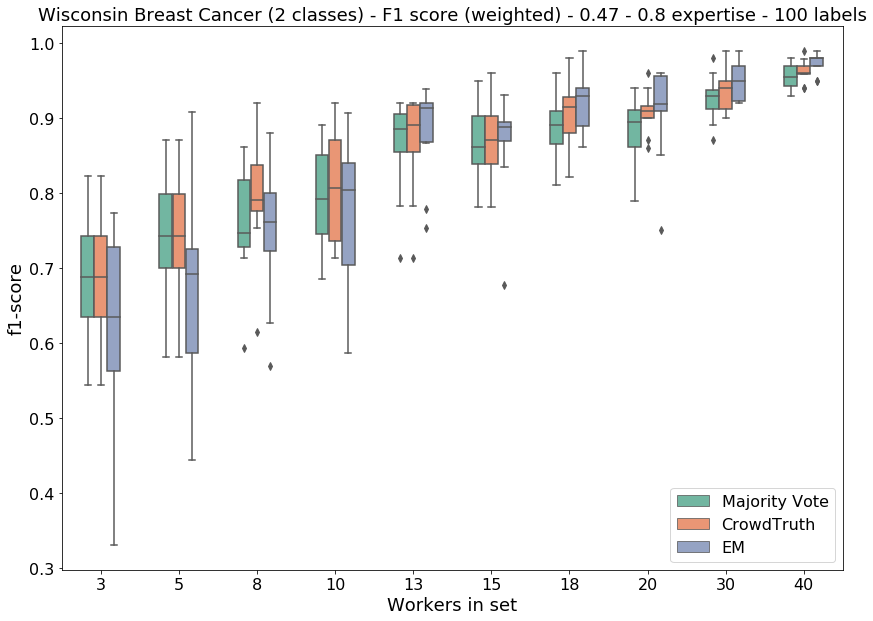

In [39]:
mv_df_scores = pd.DataFrame([cell for row in [[[k, score] for score in v['mv_f1_weighted']]for k,v in ws_exp_dict.items()] for cell in row],
                            columns=["worker_set", "score"])
mv_df_scores['type'] = "Majority Vote"
mv_df_scores['ws_num'] = mv_df_scores['worker_set'].apply(lambda x: int(x.split("_")[1]))
ct_df_scores = pd.DataFrame([cell for row in [[[k, score] for score in v['ct_f1_weighted']]for k,v in ws_exp_dict.items()] for cell in row],
                            columns=["worker_set", "score"])
ct_df_scores['type'] = "CrowdTruth"
ct_df_scores['ws_num'] = ct_df_scores['worker_set'].apply(lambda x: int(x.split("_")[1]))

em_df_scores = pd.DataFrame([cell for row in [[[k, score] for score in v['em_f1_weighted']]for k,v in ws_exp_dict.items()] for cell in row],
                            columns=["worker_set", "score"])
em_df_scores['type'] = "EM"
em_df_scores['ws_num'] = ct_df_scores['worker_set'].apply(lambda x: int(x.split("_")[1]))

ct_mv_combined = pd.concat([mv_df_scores, ct_df_scores, em_df_scores])

plt.figure(figsize=(14,10))

title_wording = "{} ({} classes) - F1 score (weighted) - {} - {} expertise - {} labels".format(dataset_name,
                                                                                               label_set,
                                                                                               round(lb_exp, 2),
                                                                                               ub_exp,
                                                                                               sample_count)

sns.boxplot(x="ws_num", y="score", hue="type", data=ct_mv_combined[ct_mv_combined['ws_num'] < 42], width=0.5, palette="Set2")
plt.title(title_wording, fontdict={"size": 18})
plt.ylabel("f1-score", fontdict={"size": 18})
plt.xlabel("Workers in set", fontdict={"size": 18})
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(prop={'size': 16}, loc="lower right")
short_name = "ng" if dataset_name == "Newsgroups" else "wbc"
plt.savefig(fp_name + "/{}_{}_{}_le_boxplot.png".format(short_name, label_set, sample_count))

### Significance testing

Below is the significance testing for each worker set of the experiment, it compares the methods against each other. Consider p<0.05 and p<0.005.

In [43]:
from scipy.stats import mannwhitneyu, kstest, shapiro, f_oneway, ttest_ind

sig_res = {k: {"anova_mv_ct": f_oneway(v['mv_f1_weighted'], v['ct_f1_weighted']).pvalue,
               "anova_mv_em": f_oneway(v['mv_f1_weighted'], v['em_f1_weighted']).pvalue,
               "anova_em_ct": f_oneway(v['ct_f1_weighted'], v['em_f1_weighted']).pvalue} for k, v in ws_exp_dict.items()}

p_vals = pd.DataFrame(sig_res).T
p_vals

,anova_mv_ct,anova_mv_em,anova_em_ct
ws_3,1.000000,0.273804,0.273804
ws_5,1.000000,0.188545,0.188545
ws_8,0.341670,0.787707,0.262325
ws_10,0.677143,0.705273,0.476559
ws_13,0.896171,0.561559,0.659740
ws_15,0.897731,0.961864,0.877565
ws_18,0.529511,0.157300,0.475320
ws_20,0.148184,0.314135,0.976908
ws_30,0.406409,0.093782,0.404228
ws_40,0.431380,0.035232,0.143577


In [53]:
p_vals.to_csv(fp_name + "/sig_test.csv")